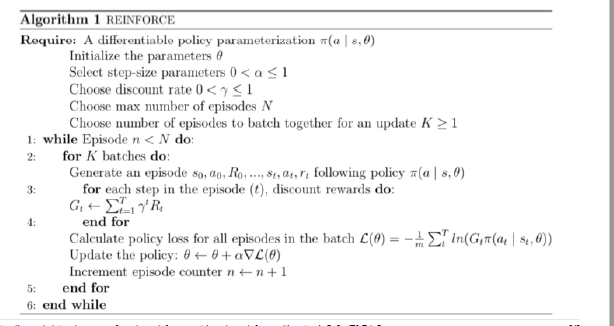

In [1]:
import numpy as np
from machine import Machine
import random
import torch
from torch import nn
import statistics
import matplotlib.pyplot as plt
import pandas as pd

#Parameters
lmd0 = 0.013364
lmd1 = 0.333442
lmdM = 1 - lmd0 - lmd1 #0.6531...
mu0 = 0.125
mu1 = 0.25
muM = 0.5


#transition matrices

#transition matrix for a = 0 (no maintenance)
a0_tm = np.array([[lmdM, lmd1, 0, 0, 0, 0, 0, 0, 0, lmd0], #current state 0 to next state
                  [0, lmdM, lmd1, 0, 0, 0, 0, 0, 0, lmd0], #current state 1 to next state
                  [0, 0, lmdM, lmd1, 0, 0, 0, 0, 0, lmd0], #current state 2 to next state
                  [0, 0, 0, lmdM, 0, 0, 0, 0, lmd1, lmd0], #current state 3 to next state
                  [muM, 0, 0, 0, 1-muM, 0, 0, 0, 0, 0], #current state 4 to next state
                  [muM, 0, 0, 0, 0, 1-muM, 0, 0, 0, 0], #current state 5 to next state
                  [0, muM, 0, 0, 0, 0, 1-muM, 0, 0, 0], #current state 6 to next state
                  [0, 0, muM, 0, 0, 0, 0, 1-muM, 0, 0], #current state 7 to next state
                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], #current state 8 to next state
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]) #current state 9 to next state


#transition matrix for a = 1 (maintenance steps)
a1_tm = np.array([[0, 0, 0, 0, 1-lmd0, 0, 0, 0, 0, lmd0], #current state 0 to next state
                  [0, 0, 0, 0, 0, 1-lmd0, 0, 0, 0, lmd0], #current state 1 to next state
                  [0, 0, 0, 0, 0, 0, 1-lmd0, 0, 0, lmd0], #current state 2 to next state
                  [0, 0, 0, 0, 0, 0, 0, 1-lmd0, 0, lmd0], #current state 3 to next state
                  [muM, 0, 0, 0, 1-muM, 0, 0, 0, 0, 0], #current state 4 to next state
                  [muM, 0, 0, 0, 0, 1-muM, 0, 0, 0, 0], #current state 5 to next state
                  [0, muM, 0, 0, 0, 0, 1-muM, 0, 0, 0], #current state 6 to next state
                  [0, 0, muM, 0, 0, 0, 0, 1-muM, 0, 0], #current state 7 to next state
                  [mu1, 0, 0, 0, 0, 0, 0, 0, 1-mu1, 0], #current state 8 to next state
                  [mu0, 0, 0, 0, 0, 0, 0, 0, 0, 1-mu0]]) #current state 9 to next state



class Machine_env():
    '''
    Description:
    Code creates an environment for the policy to interact with the simulated machine.

    States:
    The simulated machine has 10 states
    [0,1,2,3] are working states that degrades as the state number increases.
    [4,5,6,7] are maintenance states that are transited from [0,1,2,3] respectively if the action deems it need transition
    [8,9] are failure state, where 8 is sudden failure state that can occur from [0,1,2,3] while 9 is a degraded failure from 3

    Actions:
    Type: Discrete(2)
    Num
    0: No maintenance
    1: Maintenance

    Rewards:
    reward_func = {0:1000,1:900,2:800,3:500,4:-500,5:-500,6:-500,7:-500,8:-3000,9:-1000}

    Observations:
    Produced using MachineSensor class that uses gmm from pickle file

    Episode:
    Since it is continous Markov model, we shall set 1 episode is 20 steps


    Pseudo code

    initialise class
    Loop 20 times: #1 episode
        sensor()
        action()
        step()

    final otp: Class that contains rewards,actions, observations --> will be used to improve policy (ie. optimise theta)
        
''' 

    def __init__(self):
        self.action_space = [0,1]
        self.state = 0 #Random initialise the start state, assumes uniform distribution for initial state,random.randrange(10)
        self.state_seq = [] #initialise a list that records the actual states
        self.reward_func = {0:1000,1:900,2:800,3:500,4:-500,5:-500,6:-500,7:-500,8:-3000,9:-1000}
        self.observation_space = 4
        self.transition  = [a0_tm,a1_tm]
        self.simulator = Machine() #simulator to generate sensor readings
        self.done = False
        self.steps = 0
    
    def sensor(self,state): # generate observation at state
        self.simulator.curr_state = state
        sensor_reading = self.simulator.readSensors()
        return sensor_reading
    
    def step(self,action): # simulate movement of states given an action
        self.state_seq.append(self.state) #record current state
        
        transition_mat_action = self.transition[action]
        #print(f"Transition Prob: {transition_mat_action[self.state]}")
        nxt_state = np.random.choice([i for i in range(10)],1,p=transition_mat_action[self.state])[0] #select nxt state based
        reward = self.reward_func[nxt_state] #reward for going to next state
        self.state = nxt_state #update state
        
        self.steps += 1
        
        if(((nxt_state == 0) and (self.steps > 20)) or (self.steps >= 50)):#condition for end of episode
            self.done = True


        return reward
    
    def reset(self):
        self.state = 0
        self.done = False
        self.steps = 0
        self.state_seq = []
        return 
        
class policy_estimator(): #neural network
    def __init__(self, env):
        self.n_inputs = env.observation_space
        self.n_outputs = len(env.action_space)
        
        # Define network
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, 16), 
            nn.ReLU(), 
            nn.Linear(16, self.n_outputs),
        nn.Softmax(dim=-1))
        
    
    def predict(self,observation):#prediction is raw value
        return self.network(torch.FloatTensor(observation))

In [2]:
def discount_rewards(rewards, gamma):
    r = np.array([gamma**i * rewards[i] 
        for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    return r 

def normalized_discount_reward(rewards,gamma):
    r = np.array([gamma**i * rewards[i] 
        for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    r = np.array(r)
    mean_rewards=np.mean(r)
    std_rewards=np.std(r)
    norm_discounted_rewards=(r-mean_rewards)/(std_rewards+1e-12)
    return norm_discounted_rewards.tolist()

def reinforce(machine,policy_estimator,num_episodes,batch_size,gamma,lr): #Learning algo
    # Set up lists to hold results
    # Set up lists to hold results
    total_rewards = [] #Total actual reward for each episode
    batch_rewards = []  #Discounted expected future rewards for each batch
    batch_actions = []
    batch_observation = []
    state_seq = []
    
    # Define optimizer
    optimizer = torch.optim.Adam(policy_estimator.network.parameters(),lr=lr)
    
    action_space = machine.action_space
    
    for ep in range(num_episodes):
        machine.reset()
        observation = []
        rewards = []
        actions = []
        
        while(not machine.done):
            obs = machine.sensor(machine.state).tolist() #observation
            
            action_probs = policy_estimator.predict(obs).detach().numpy() #convert to numpy and get action prob
            action = np.random.choice(action_space, p=action_probs) #select weighted actions based on NN output prob
            print(f"Action prob: {action_probs}, Action: {action}, state: {machine.state}")
            
            r = machine.step(action) #receive reward and update machine to the next state after doing the sampled action
            
            observation.append(obs)
            rewards.append(r)
            actions.append(action)
        
        discount_r = normalized_discount_reward(rewards,gamma) #normalised future rewards
        
        total_rewards.append(sum(rewards)) #Cumulative reward for this episode
        
        #After batch complete time,store the parameters
        batch_rewards.append(discount_r)
        batch_observation.append(observation)
        batch_actions.append(actions)
        state_seq.append(machine.state_seq)
        
        #update policy
        obs_tensor = torch.FloatTensor(observation)
        action_tensor = torch.LongTensor(actions)
        reward_tensor = torch.from_numpy(np.array(discount_r).copy()) #resolve stride problem
        
        # Calculate loss Ver 1
#         logits = policy_estimator.predict(obs_tensor)
#         policy_distribution = torch.distributions.Categorical(logits = logits)
#         log_probs = policy_distribution.log_prob(action_tensor)
#         print(log_probs*reward_tensor)
#         loss = -(log_probs*reward_tensor).mean()
        
        
        
    # Calculate loss Ver 2
#         logprob = torch.log(policy_estimator.predict(obs_tensor))
#         selected_logprobs = reward_tensor * torch.gather(logprob,-1,action_tensor.unsqueeze(-1)).squeeze(-1)
#         print(selected_logprobs)
#         loss = -selected_logprobs.mean()

        #Calculate loss Ver 3
        logprob = torch.log(policy_estimator.predict(obs_tensor))
        #print(logprob)
        #print(logprob[np.arange(len(action_tensor)), action_tensor])
        selected_logprobs = reward_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
        print(selected_logprobs)
        
        
        loss = -selected_logprobs.mean()
        
        print(f"Reward for this episode {total_rewards[-1]}, loss is {loss}")
        
        optimizer.zero_grad()
        # Calculate gradients
        loss.backward()
        # Apply gradients
        optimizer.step()
        
#         #Tensorboard params
#         writer.add_scalar("Loss", loss, ep)
#         writer.add_scalar('Rewards',sum(rewards),ep)
#         for name, weight in policy_estimator.network.named_parameters():
#             try:
#                 writer.add_histogram(name,weight, ep)
#             except:
#                 continue
#             if weight.grad != None:
#                 writer.add_histogram(f"{name}.grad",weight.grad, ep)
    
#     writer.add_graph(policy_estimator.network,torch.FloatTensor(machine.sensor(0))) #draw graph
#     writer.flush()
#     writer.close()
    
    return (total_rewards,batch_actions,state_seq)

In [3]:
def entropy(distribution,entropy_coeff):
    entropy = 0
    x = distribution.detach().numpy()
    for row in x:
        entropy += -np.sum(row + np.log(row))

    ave_entropy = entropy/len(x)
    return ave_entropy*entropy_coeff

In [4]:
from torch.utils.tensorboard import SummaryWriter

# Normal REINFORCE

C:\Users\overl\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Action prob: [0.50585335 0.49414667], Action: 0, state: 0
Action prob: [0.49812436 0.5018757 ], Action: 0, state: 0
Action prob: [0.5008278  0.49917215], Action: 1, state: 0
Action prob: [0.46628308 0.5337169 ], Action: 0, state: 4
Action prob: [0.50355905 0.49644095], Action: 1, state: 0
Action prob: [0.46628308 0.5337169 ], Action: 1, state: 4
Action prob: [0.50054145 0.49945858], Action: 1, state: 0
Action prob: [0.46628308 0.5337169 ], Action: 1, state: 4
Action prob: [0.5024651  0.49753484], Action: 1, state: 0
Action prob: [0.46628308 0.5337169 ], Action: 1, state: 4
Action prob: [0.49730906 0.5026909 ], Action: 0, state: 0
Action prob: [0.501205 0.498795], Action: 1, state: 1
Action prob: [0.46628308 0.5337169 ], Action: 0, state: 5
Action prob: [0.46628308 0.5337169 ], Action: 0, state: 5
Action prob: [0.46628308 0.5337169 ], Action: 0, state: 5
Action prob: [0.49777123 0.50222874], Action: 0, state: 0
Action prob: [0.49821383 0.50178623], Action: 0, state: 1
Action prob: [0.50

Action prob: [0.7959728  0.20402715], Action: 0, state: 2
Action prob: [0.79315466 0.20684533], Action: 0, state: 2
Action prob: [0.79411954 0.20588045], Action: 1, state: 2
Action prob: [0.7913356  0.20866445], Action: 0, state: 6
Action prob: [0.79200023 0.20799983], Action: 0, state: 1
Action prob: [0.7973815  0.20261846], Action: 0, state: 1
Action prob: [0.794361   0.20563893], Action: 0, state: 2
Action prob: [0.7951001  0.20489997], Action: 0, state: 3
Action prob: [0.78982514 0.21017489], Action: 0, state: 3
Action prob: [0.83052844 0.16947153], Action: 0, state: 8
Action prob: [0.78893816 0.21106187], Action: 0, state: 8
Action prob: [0.79633886 0.20366113], Action: 1, state: 8
Action prob: [0.79522413 0.20477583], Action: 0, state: 8
Action prob: [0.82123053 0.17876945], Action: 0, state: 8
Action prob: [0.79205054 0.20794944], Action: 0, state: 8
Action prob: [0.8249526  0.17504735], Action: 1, state: 8
Action prob: [0.7941097  0.20589025], Action: 0, state: 8
Action prob: [

Action prob: [0.9464336  0.05356647], Action: 0, state: 2
Action prob: [0.95186466 0.04813535], Action: 0, state: 2
Action prob: [0.9445162 0.0554838], Action: 0, state: 3
Action prob: [0.94826967 0.05173031], Action: 0, state: 3
Action prob: [0.94979364 0.05020638], Action: 0, state: 3
Action prob: [0.9483193  0.05168062], Action: 0, state: 8
Action prob: [0.94062823 0.05937174], Action: 0, state: 8
Action prob: [0.941985   0.05801498], Action: 0, state: 8
Action prob: [0.9417261  0.05827389], Action: 0, state: 8
Action prob: [0.94526213 0.05473789], Action: 0, state: 8
Action prob: [0.9468985  0.05310153], Action: 0, state: 8
Action prob: [0.9500048  0.04999514], Action: 0, state: 8
Action prob: [0.9455666  0.05443345], Action: 0, state: 8
Action prob: [0.9563701 0.0436299], Action: 0, state: 8
Action prob: [0.943644   0.05635605], Action: 0, state: 8
Action prob: [0.9512778  0.04872228], Action: 0, state: 8
Action prob: [0.9412731  0.05872684], Action: 0, state: 8
Action prob: [0.95

Action prob: [0.96047777 0.03952223], Action: 0, state: 2
Action prob: [0.96379673 0.03620333], Action: 0, state: 3
Action prob: [0.9555456  0.04445435], Action: 0, state: 8
Action prob: [0.9739328  0.02606723], Action: 0, state: 8
Action prob: [0.9540229  0.04597706], Action: 0, state: 8
Action prob: [0.97402734 0.02597259], Action: 0, state: 8
Action prob: [0.9667045  0.03329551], Action: 0, state: 8
Action prob: [0.97296053 0.02703947], Action: 0, state: 8
Action prob: [0.95659137 0.04340867], Action: 0, state: 8
Action prob: [0.9580106  0.04198937], Action: 0, state: 8
Action prob: [0.9655267  0.03447334], Action: 0, state: 8
Action prob: [0.95148104 0.04851899], Action: 0, state: 8
Action prob: [0.95554674 0.0444533 ], Action: 0, state: 8
Action prob: [0.95558363 0.04441639], Action: 0, state: 8
Action prob: [0.9634658  0.03653415], Action: 0, state: 8
Action prob: [0.96390337 0.03609662], Action: 0, state: 8
Action prob: [0.96587414 0.03412586], Action: 0, state: 8
Action prob: [

Action prob: [0.9766758  0.02332419], Action: 0, state: 0
Action prob: [0.9788479  0.02115211], Action: 0, state: 1
Action prob: [0.9778528  0.02214719], Action: 0, state: 1
Action prob: [0.97765094 0.02234902], Action: 0, state: 2
Action prob: [0.97754204 0.02245798], Action: 0, state: 2
Action prob: [0.97793293 0.02206711], Action: 0, state: 3
Action prob: [0.9754024  0.02459755], Action: 0, state: 9
Action prob: [0.9817499  0.01825008], Action: 0, state: 9
Action prob: [0.9749349 0.0250651], Action: 0, state: 9
Action prob: [0.9805741  0.01942598], Action: 0, state: 9
Action prob: [0.97628284 0.02371708], Action: 0, state: 9
Action prob: [0.9847114  0.01528858], Action: 0, state: 9
Action prob: [0.9742305 0.0257695], Action: 0, state: 9
Action prob: [0.9852555  0.01474452], Action: 0, state: 9
Action prob: [0.97812176 0.02187821], Action: 0, state: 9
Action prob: [0.98546046 0.0145396 ], Action: 0, state: 9
Action prob: [0.9740399  0.02596008], Action: 0, state: 9
Action prob: [0.97

Action prob: [0.9677618  0.03223811], Action: 0, state: 9
Action prob: [0.97469306 0.02530694], Action: 0, state: 9
Action prob: [0.9750866  0.02491335], Action: 0, state: 9
Action prob: [0.971503   0.02849695], Action: 0, state: 9
Action prob: [0.97998214 0.02001785], Action: 0, state: 9
Action prob: [0.9657597  0.03424032], Action: 0, state: 9
Action prob: [0.98102826 0.01897167], Action: 0, state: 9
Action prob: [0.97434694 0.025653  ], Action: 0, state: 9
Action prob: [0.9631613  0.03683867], Action: 0, state: 9
Action prob: [0.96409565 0.03590437], Action: 0, state: 9
Action prob: [0.9713698  0.02863021], Action: 0, state: 9
Action prob: [0.9715649  0.02843504], Action: 0, state: 9
Action prob: [0.9752417  0.02475832], Action: 0, state: 9
Action prob: [0.97093606 0.02906395], Action: 0, state: 9
Action prob: [0.9669485  0.03305152], Action: 0, state: 9
Action prob: [0.9700013  0.02999869], Action: 1, state: 9
Action prob: [0.96704936 0.03295061], Action: 0, state: 9
Action prob: [

Action prob: [0.95394135 0.04605868], Action: 0, state: 3
Action prob: [0.9465139  0.05348609], Action: 0, state: 8
Action prob: [0.95521    0.04478999], Action: 0, state: 8
Action prob: [0.9467365  0.05326345], Action: 0, state: 8
Action prob: [0.965136   0.03486394], Action: 0, state: 8
Action prob: [0.9461254  0.05387465], Action: 0, state: 8
Action prob: [0.9662207  0.03377932], Action: 0, state: 8
Action prob: [0.96225005 0.03774998], Action: 0, state: 8
Action prob: [0.9549443  0.04505569], Action: 0, state: 8
Action prob: [0.9510654  0.04893464], Action: 0, state: 8
Action prob: [0.9484397 0.0515603], Action: 0, state: 8
Action prob: [0.94967073 0.05032929], Action: 0, state: 8
Action prob: [0.9635038  0.03649618], Action: 0, state: 8
Action prob: [0.9498852  0.05011485], Action: 0, state: 8
Action prob: [0.9473354  0.05266454], Action: 0, state: 8
Action prob: [0.96382165 0.03617833], Action: 1, state: 8
Action prob: [0.95471454 0.04528543], Action: 0, state: 0
tensor([ 4.5428e

Action prob: [0.8815557  0.11844429], Action: 0, state: 1
Action prob: [0.88529253 0.11470743], Action: 0, state: 2
Action prob: [0.8833942  0.11660578], Action: 0, state: 3
Action prob: [0.88047945 0.11952052], Action: 1, state: 3
Action prob: [0.9826765  0.01732352], Action: 0, state: 7
Action prob: [0.8850323  0.11496772], Action: 1, state: 2
Action prob: [0.9826765  0.01732352], Action: 0, state: 6
Action prob: [0.9826765  0.01732352], Action: 0, state: 6
Action prob: [0.88287383 0.11712614], Action: 0, state: 1
Action prob: [0.87814385 0.12185612], Action: 1, state: 2
Action prob: [0.9826765  0.01732352], Action: 0, state: 6
Action prob: [0.8808223  0.11917774], Action: 0, state: 1
Action prob: [0.8842404  0.11575962], Action: 0, state: 1
Action prob: [0.88080627 0.11919373], Action: 0, state: 2
Action prob: [0.8823742  0.11762577], Action: 0, state: 3
Action prob: [0.8837409  0.11625909], Action: 0, state: 3
Action prob: [0.884165 0.115835], Action: 0, state: 3
Action prob: [0.89

Action prob: [0.8303516  0.16964838], Action: 0, state: 1
Action prob: [0.83055854 0.16944143], Action: 0, state: 1
Action prob: [0.828262   0.17173807], Action: 0, state: 2
Action prob: [0.8333684  0.16663164], Action: 0, state: 2
Action prob: [0.8337218  0.16627821], Action: 0, state: 2
Action prob: [0.8319225 0.1680775], Action: 0, state: 2
Action prob: [0.8299629 0.1700371], Action: 0, state: 3
Action prob: [0.8282434  0.17175661], Action: 0, state: 3
Action prob: [0.83118975 0.1688102 ], Action: 0, state: 3
Action prob: [0.83234364 0.16765639], Action: 0, state: 3
Action prob: [0.82956165 0.1704383 ], Action: 0, state: 3
Action prob: [0.83460325 0.16539675], Action: 0, state: 8
Action prob: [0.8212711  0.17872885], Action: 0, state: 8
Action prob: [0.819032   0.18096794], Action: 0, state: 8
Action prob: [0.8296024 0.1703975], Action: 0, state: 8
Action prob: [0.8270983  0.17290169], Action: 0, state: 8
Action prob: [0.8207434  0.17925665], Action: 0, state: 8
Action prob: [0.8191

Action prob: [0.7714207  0.22857928], Action: 0, state: 8
Action prob: [0.77160096 0.22839907], Action: 0, state: 8
Action prob: [0.7857686  0.21423142], Action: 0, state: 8
Action prob: [0.772194   0.22780593], Action: 1, state: 8
Action prob: [0.7743393  0.22566074], Action: 0, state: 8
Action prob: [0.78445786 0.2155421 ], Action: 0, state: 8
Action prob: [0.77396536 0.2260347 ], Action: 0, state: 8
Action prob: [0.7772536  0.22274631], Action: 1, state: 8
tensor([-4.1628, -0.3568, -0.6069, -0.4111, -1.6009, -0.1449, -0.2135, -0.1114,
        -0.0314,  0.0276,  0.0784,  0.1203,  0.1588,  1.0638,  0.0696,  0.1826,
         0.1898,  1.2501,  0.0852,  0.0820,  0.1968,  0.2125,  0.1727,  0.1583,
         0.1395,  0.7189,  0.1093,  0.0926,  0.0812,  0.0774,  0.4070,  0.0625,
         0.0569,  0.0486,  0.2753,  0.0443,  0.0393,  0.0391,  0.2169],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for this episode -40000, loss is 0.030315812210758367
Action prob: [0.7594329  0.2405

Action prob: [0.755983   0.24401703], Action: 0, state: 0
Action prob: [0.7583275  0.24167252], Action: 0, state: 1
Action prob: [0.75753206 0.24246794], Action: 1, state: 1
Action prob: [0.77621865 0.22378139], Action: 0, state: 5
Action prob: [0.77621865 0.22378139], Action: 0, state: 5
Action prob: [0.77621865 0.22378139], Action: 1, state: 5
Action prob: [0.77621865 0.22378139], Action: 1, state: 5
tensor([-0.7956, -0.5472, -1.7244, -0.3991, -0.2719, -0.1311, -0.0083,  0.4794,
         0.0463,  0.6352,  0.5035,  0.0608,  0.1131,  0.1481,  0.9330,  0.1548,
         0.1948,  0.2108,  1.1583,  0.2004,  0.1948,  1.1228,  1.0986],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for this episode 9100, loss is -0.14683459209481323
Action prob: [0.7695024  0.23049763], Action: 1, state: 0
Action prob: [0.7702872  0.22971277], Action: 0, state: 4
Action prob: [0.7702872  0.22971277], Action: 0, state: 4
Action prob: [0.7702872  0.22971277], Action: 0, state: 4
Action prob: [0.770

Action prob: [0.82028157 0.17971843], Action: 0, state: 8
Action prob: [0.8041793  0.19582072], Action: 0, state: 8
Action prob: [0.8078958  0.19210419], Action: 0, state: 8
Action prob: [0.7891772  0.21082284], Action: 0, state: 8
Action prob: [0.7946308  0.20536919], Action: 0, state: 8
Action prob: [0.7850343  0.21496573], Action: 0, state: 8
Action prob: [0.8040624  0.19593759], Action: 0, state: 8
Action prob: [0.80726004 0.19273996], Action: 0, state: 8
Action prob: [0.7925032  0.20749688], Action: 0, state: 8
Action prob: [0.80541366 0.19458638], Action: 0, state: 8
Action prob: [0.79331213 0.20668785], Action: 0, state: 8
tensor([-7.7991e-01, -5.3631e-01, -3.1096e-01, -1.4189e-01,  4.0101e-04,
         1.1028e-01,  2.0316e-01,  2.4973e-01,  2.1434e+00,  2.7945e-01,
         3.0235e-01,  3.4619e-01,  3.8477e-01,  4.0205e-01,  4.1580e-01,
         3.5365e-01,  2.5270e-01,  1.4604e+00,  1.7412e-01,  1.2341e-01,
         5.7919e-01,  5.5412e-02,  2.5005e-02,  4.3098e-03, -1.4068e-0

Action prob: [0.84245956 0.1575405 ], Action: 0, state: 8
Action prob: [0.8322483  0.16775179], Action: 0, state: 8
Action prob: [0.85745543 0.14254463], Action: 0, state: 8
Action prob: [0.8440887 0.1559113], Action: 0, state: 8
Action prob: [0.85843265 0.14156736], Action: 0, state: 8
Action prob: [0.85441816 0.14558186], Action: 0, state: 8
Action prob: [0.83422625 0.16577375], Action: 0, state: 8
Action prob: [0.8399422  0.16005774], Action: 0, state: 8
Action prob: [0.83437854 0.16562149], Action: 1, state: 8
Action prob: [0.85268086 0.14731908], Action: 0, state: 8
Action prob: [0.8502436  0.14975637], Action: 0, state: 8
tensor([-0.5323, -0.3319, -0.1815, -0.0499,  0.0615,  0.1569,  0.2365,  2.9044,
         0.3055,  0.2695,  0.2422,  0.2737,  0.2835,  0.2939,  0.3211,  0.2246,
         0.1686,  0.1491,  0.0997,  0.0696,  0.0509,  0.0268,  0.0047, -0.0117,
        -0.0246, -0.0421, -0.0457, -0.0530, -0.7050, -0.0667, -0.0777, -0.0773,
        -0.0918, -0.0910, -0.0939, -0.1016, 

Action prob: [0.9346297  0.06537025], Action: 0, state: 8
Action prob: [0.93251514 0.06748482], Action: 0, state: 8
Action prob: [0.91618377 0.08381627], Action: 0, state: 8
Action prob: [0.9337367  0.06626336], Action: 0, state: 8
Action prob: [0.9222171  0.07778291], Action: 0, state: 8
Action prob: [0.91777426 0.08222581], Action: 0, state: 8
Action prob: [0.9169485  0.08305155], Action: 0, state: 8
Action prob: [0.9216959  0.07830405], Action: 0, state: 8
Action prob: [0.9334154  0.06658453], Action: 0, state: 8
Action prob: [0.91714287 0.08285711], Action: 0, state: 8
Action prob: [0.93437535 0.0656246 ], Action: 0, state: 8
Action prob: [0.93318075 0.06681922], Action: 0, state: 8
Action prob: [0.9203578  0.07964221], Action: 0, state: 8
Action prob: [0.91240424 0.08759581], Action: 0, state: 8
Action prob: [0.9355833  0.06441669], Action: 0, state: 8
Action prob: [0.9367958  0.06320424], Action: 0, state: 8
Action prob: [0.91627747 0.08372253], Action: 0, state: 8
Action prob: [

Action prob: [0.95885485 0.0411451 ], Action: 0, state: 9
Action prob: [0.94269043 0.05730958], Action: 0, state: 9
Action prob: [0.9404583  0.05954165], Action: 0, state: 9
Action prob: [0.9605966  0.03940338], Action: 0, state: 9
Action prob: [0.9430054  0.05699464], Action: 0, state: 9
Action prob: [0.96762264 0.03237736], Action: 0, state: 9
Action prob: [0.93998486 0.0600152 ], Action: 0, state: 9
Action prob: [0.9519572  0.04804278], Action: 0, state: 9
Action prob: [0.9601354  0.03986461], Action: 0, state: 9
Action prob: [0.9603195  0.03968046], Action: 0, state: 9
Action prob: [0.9498019  0.05019807], Action: 0, state: 9
Action prob: [0.9552847  0.04471531], Action: 0, state: 9
Action prob: [0.96041757 0.03958246], Action: 0, state: 9
Action prob: [0.9419894 0.0580106], Action: 0, state: 9
Action prob: [0.9621062  0.03789375], Action: 0, state: 9
Action prob: [0.95915985 0.04084014], Action: 0, state: 9
tensor([-1.8696e-01, -1.2340e-01, -7.1816e-02, -3.1030e-02,  8.1697e-03,
 

Action prob: [0.97759557 0.02240435], Action: 0, state: 8
Action prob: [0.9798753  0.02012471], Action: 0, state: 8
Action prob: [0.9819701  0.01802996], Action: 0, state: 8
Action prob: [0.97064567 0.0293543 ], Action: 0, state: 8
Action prob: [0.9696041  0.03039592], Action: 0, state: 8
Action prob: [0.97797763 0.02202237], Action: 0, state: 8
Action prob: [0.98413426 0.01586567], Action: 0, state: 8
Action prob: [0.96959764 0.03040239], Action: 0, state: 8
Action prob: [0.9681218  0.03187816], Action: 0, state: 8
Action prob: [0.97934544 0.02065452], Action: 0, state: 8
Action prob: [0.97021925 0.02978068], Action: 0, state: 8
Action prob: [0.9671181  0.03288193], Action: 0, state: 8
Action prob: [0.9833135  0.01668654], Action: 0, state: 8
Action prob: [0.97132295 0.0286771 ], Action: 0, state: 8
Action prob: [0.9824997  0.01750027], Action: 0, state: 8
Action prob: [0.9677921  0.03220795], Action: 0, state: 8
Action prob: [0.9827823  0.01721766], Action: 0, state: 8
Action prob: [

       dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for this episode -115800, loss is 0.06500976921370405
Action prob: [0.9856741  0.01432596], Action: 0, state: 0
Action prob: [0.98638064 0.01361935], Action: 0, state: 0
Action prob: [0.9866803  0.01331968], Action: 0, state: 0
Action prob: [0.98568046 0.01431956], Action: 0, state: 0
Action prob: [0.9858596  0.01414048], Action: 0, state: 0
Action prob: [0.98640037 0.01359966], Action: 0, state: 0
Action prob: [0.98563856 0.01436142], Action: 0, state: 1
Action prob: [0.98255986 0.0174401 ], Action: 0, state: 1
Action prob: [0.9853277  0.01467229], Action: 0, state: 1
Action prob: [0.98446655 0.01553348], Action: 0, state: 2
Action prob: [0.98565453 0.01434551], Action: 0, state: 2
Action prob: [0.98603016 0.01396982], Action: 0, state: 2
Action prob: [0.98621815 0.0137818 ], Action: 0, state: 2
Action prob: [0.98585397 0.01414601], Action: 0, state: 2
Action prob: [0.9875031  0.01249686], Action: 0, state: 2
Action prob: [0.9

Action prob: [0.99145824 0.00854176], Action: 0, state: 2
Action prob: [0.99257326 0.00742677], Action: 0, state: 2
Action prob: [0.99321175 0.00678824], Action: 0, state: 2
Action prob: [0.9918926  0.00810747], Action: 0, state: 2
Action prob: [0.9934744  0.00652561], Action: 0, state: 3
Action prob: [0.9941338  0.00586622], Action: 1, state: 3
Action prob: [0.8441349  0.15586504], Action: 0, state: 7
Action prob: [0.992019   0.00798099], Action: 0, state: 2
Action prob: [0.99203426 0.00796572], Action: 0, state: 2
Action prob: [0.9916469  0.00835304], Action: 0, state: 3
Action prob: [0.9950458  0.00495421], Action: 0, state: 8
Action prob: [0.9924614  0.00753861], Action: 0, state: 8
Action prob: [0.9885514  0.01144859], Action: 0, state: 8
Action prob: [0.98897374 0.01102623], Action: 0, state: 8
Action prob: [0.99129534 0.00870462], Action: 0, state: 8
Action prob: [0.9922052  0.00779483], Action: 0, state: 8
Action prob: [0.9942245 0.0057755], Action: 1, state: 8
Action prob: [0.

Action prob: [0.9921812  0.00781886], Action: 0, state: 8
Action prob: [0.99333173 0.00666826], Action: 0, state: 8
Action prob: [0.9927832  0.00721684], Action: 0, state: 8
Action prob: [0.99732035 0.00267969], Action: 0, state: 8
Action prob: [0.992986   0.00701401], Action: 0, state: 8
Action prob: [0.9965263  0.00347372], Action: 0, state: 8
Action prob: [0.99785966 0.00214029], Action: 0, state: 8
Action prob: [0.9962548  0.00374524], Action: 0, state: 8
Action prob: [0.9924705  0.00752951], Action: 0, state: 8
Action prob: [0.9975715  0.00242847], Action: 0, state: 8
Action prob: [0.9966354  0.00336468], Action: 0, state: 8
Action prob: [0.99392277 0.00607722], Action: 0, state: 8
Action prob: [0.9939097  0.00609028], Action: 0, state: 8
Action prob: [0.9961737  0.00382636], Action: 0, state: 8
Action prob: [0.99276394 0.00723611], Action: 0, state: 8
Action prob: [0.9936139  0.00638607], Action: 0, state: 8
Action prob: [0.9954886  0.00451144], Action: 0, state: 8
Action prob: [

Action prob: [0.9982316  0.00176847], Action: 0, state: 0
Action prob: [0.9988668  0.00113327], Action: 0, state: 0
Action prob: [0.9981071  0.00189291], Action: 0, state: 0
Action prob: [0.9980615  0.00193846], Action: 0, state: 0
Action prob: [0.9983121  0.00168785], Action: 0, state: 0
Action prob: [0.9980811  0.00191896], Action: 0, state: 0
Action prob: [0.99806494 0.00193507], Action: 0, state: 0
Action prob: [0.99836    0.00163997], Action: 0, state: 1
Action prob: [0.9984944  0.00150555], Action: 0, state: 1
Action prob: [0.9981541  0.00184591], Action: 0, state: 2
Action prob: [0.9979837  0.00201625], Action: 0, state: 2
Action prob: [0.99792814 0.0020719 ], Action: 0, state: 2
Action prob: [0.99854493 0.00145506], Action: 0, state: 3
Action prob: [0.9984571  0.00154292], Action: 0, state: 8
Action prob: [0.99893564 0.0010643 ], Action: 0, state: 8
Action prob: [9.9903905e-01 9.6101972e-04], Action: 0, state: 8
Action prob: [0.9988746  0.00112535], Action: 0, state: 8
Action p

Action prob: [9.9910200e-01 8.9804595e-04], Action: 0, state: 8
Action prob: [9.9932146e-01 6.7854091e-04], Action: 0, state: 8
Action prob: [0.9984602  0.00153982], Action: 0, state: 8
Action prob: [9.9942231e-01 5.7773513e-04], Action: 0, state: 8
Action prob: [9.9952054e-01 4.7947338e-04], Action: 0, state: 8
Action prob: [9.995340e-01 4.659873e-04], Action: 0, state: 8
Action prob: [0.9979406  0.00205938], Action: 0, state: 8
Action prob: [0.9979457  0.00205429], Action: 0, state: 8
Action prob: [9.9920732e-01 7.9275144e-04], Action: 0, state: 8
Action prob: [0.99827063 0.00172936], Action: 0, state: 8
Action prob: [9.9956566e-01 4.3436707e-04], Action: 0, state: 8
Action prob: [9.992594e-01 7.405755e-04], Action: 0, state: 8
Action prob: [9.9927276e-01 7.2718569e-04], Action: 0, state: 8
Action prob: [9.9931443e-01 6.8559655e-04], Action: 0, state: 8
Action prob: [9.9927694e-01 7.2306511e-04], Action: 0, state: 8
Action prob: [9.9943322e-01 5.6678633e-04], Action: 0, state: 8
Acti

Action prob: [9.9953759e-01 4.6243452e-04], Action: 0, state: 8
Action prob: [0.9989213  0.00107879], Action: 0, state: 8
Action prob: [9.9984062e-01 1.5940939e-04], Action: 0, state: 8
Action prob: [9.9968863e-01 3.1133834e-04], Action: 0, state: 8
Action prob: [9.9951315e-01 4.8690429e-04], Action: 0, state: 8
Action prob: [0.9987207  0.00127931], Action: 0, state: 8
Action prob: [9.9959928e-01 4.0079062e-04], Action: 0, state: 8
tensor([ 2.7491e-04,  5.2813e-04,  8.0281e-04,  9.5111e-04,  1.3261e-03,
         1.6886e-03,  1.1901e-03,  1.7524e-03,  2.9824e-03,  5.4437e-04,
         3.9810e-04,  2.6590e-04,  9.6445e-04,  6.1629e-04,  1.1118e-04,
         4.3526e-05, -3.1429e-06, -4.7458e-05, -2.7343e-04, -9.8593e-05,
        -1.3597e-04, -2.3069e-04, -2.2282e-04, -2.2906e-04, -8.4271e-04,
        -2.4517e-04, -3.8279e-04, -2.6340e-04, -5.1939e-04, -9.2000e-04,
        -2.6447e-04, -1.0123e-03, -3.1712e-04, -8.3270e-04, -3.6254e-04,
        -6.5478e-04, -1.9783e-04, -1.3100e-03, -3.624

Reward for this episode -134900, loss is 2.5997649954641972e-05
Action prob: [9.996069e-01 3.931048e-04], Action: 0, state: 0
Action prob: [9.995389e-01 4.611012e-04], Action: 0, state: 0
Action prob: [9.9963653e-01 3.6344919e-04], Action: 0, state: 1
Action prob: [9.9962306e-01 3.7688625e-04], Action: 0, state: 1
Action prob: [9.9959189e-01 4.0810634e-04], Action: 0, state: 2
Action prob: [9.9976605e-01 2.3397651e-04], Action: 0, state: 3
Action prob: [9.9967325e-01 3.2676241e-04], Action: 0, state: 3
Action prob: [9.993228e-01 6.772924e-04], Action: 0, state: 3
Action prob: [9.9977309e-01 2.2690378e-04], Action: 0, state: 3
Action prob: [9.9920136e-01 7.9870375e-04], Action: 0, state: 8
Action prob: [9.9979645e-01 2.0357988e-04], Action: 0, state: 8
Action prob: [9.9960667e-01 3.9337139e-04], Action: 0, state: 8
Action prob: [9.991373e-01 8.626644e-04], Action: 0, state: 8
Action prob: [9.9975115e-01 2.4878950e-04], Action: 0, state: 8
Action prob: [9.9968922e-01 3.1082382e-04], Acti

Action prob: [9.9949729e-01 5.0267106e-04], Action: 0, state: 8
Action prob: [0.9988286  0.00117143], Action: 0, state: 8
Action prob: [9.9942470e-01 5.7532714e-04], Action: 0, state: 8
Action prob: [9.997328e-01 2.672144e-04], Action: 0, state: 8
Action prob: [9.9931586e-01 6.8415113e-04], Action: 0, state: 8
Action prob: [0.99895906 0.00104095], Action: 0, state: 8
Action prob: [9.997874e-01 2.126279e-04], Action: 0, state: 8
Action prob: [0.9988065  0.00119348], Action: 0, state: 8
Action prob: [9.9975318e-01 2.4678494e-04], Action: 0, state: 8
Action prob: [9.9913055e-01 8.6942286e-04], Action: 0, state: 8
Action prob: [9.991328e-01 8.671630e-04], Action: 0, state: 8
Action prob: [9.9979860e-01 2.0140091e-04], Action: 0, state: 8
Action prob: [9.997421e-01 2.578886e-04], Action: 0, state: 8
Action prob: [9.9902976e-01 9.7027695e-04], Action: 0, state: 8
Action prob: [0.99880385 0.00119611], Action: 0, state: 8
Action prob: [9.9973613e-01 2.6381318e-04], Action: 0, state: 8
Action p

Action prob: [9.9968243e-01 3.1753693e-04], Action: 0, state: 9
Action prob: [9.9961638e-01 3.8358002e-04], Action: 0, state: 9
Action prob: [0.9989636  0.00103641], Action: 0, state: 9
Action prob: [0.9988558  0.00114413], Action: 0, state: 9
Action prob: [9.9971062e-01 2.8937266e-04], Action: 0, state: 9
Action prob: [9.9962449e-01 3.7544392e-04], Action: 0, state: 9
Action prob: [0.99896836 0.00103159], Action: 0, state: 9
Action prob: [0.99862325 0.0013767 ], Action: 0, state: 9
Action prob: [0.9987675  0.00123251], Action: 0, state: 9
Action prob: [0.998923   0.00107701], Action: 0, state: 9
Action prob: [0.99899536 0.00100468], Action: 0, state: 9
Action prob: [9.997094e-01 2.905304e-04], Action: 0, state: 9
Action prob: [9.9968469e-01 3.1535843e-04], Action: 0, state: 9
Action prob: [9.9956089e-01 4.3905285e-04], Action: 0, state: 9
Action prob: [0.9988306  0.00116941], Action: 0, state: 9
Action prob: [0.9978405  0.00215941], Action: 0, state: 9
Action prob: [9.9983096e-01 1.68

Action prob: [9.994178e-01 5.822312e-04], Action: 0, state: 8
Action prob: [0.9985098  0.00149014], Action: 0, state: 8
Action prob: [0.9984971  0.00150289], Action: 0, state: 8
Action prob: [9.9965894e-01 3.4101174e-04], Action: 0, state: 8
Action prob: [9.9961960e-01 3.8032568e-04], Action: 0, state: 8
Action prob: [9.996773e-01 3.226551e-04], Action: 0, state: 8
Action prob: [9.9967861e-01 3.2139916e-04], Action: 0, state: 8
Action prob: [9.997260e-01 2.739668e-04], Action: 0, state: 8
Action prob: [0.99876297 0.00123707], Action: 0, state: 8
Action prob: [9.9950540e-01 4.9456576e-04], Action: 0, state: 8
Action prob: [0.99854517 0.00145491], Action: 0, state: 8
Action prob: [9.9966490e-01 3.3512642e-04], Action: 0, state: 8
Action prob: [0.9986376  0.00136243], Action: 0, state: 8
Action prob: [9.9961901e-01 3.8095456e-04], Action: 0, state: 8
Action prob: [9.996320e-01 3.680033e-04], Action: 0, state: 8
Action prob: [0.9989538  0.00104618], Action: 0, state: 8
Action prob: [0.9986

Action prob: [0.998415   0.00158504], Action: 0, state: 8
Action prob: [9.992448e-01 7.552675e-04], Action: 0, state: 8
Action prob: [9.99516e-01 4.84011e-04], Action: 0, state: 8
Action prob: [9.9946886e-01 5.3113210e-04], Action: 0, state: 8
Action prob: [0.99852896 0.00147105], Action: 0, state: 8
Action prob: [9.9947160e-01 5.2843883e-04], Action: 0, state: 8
Action prob: [9.9906284e-01 9.3717891e-04], Action: 0, state: 8
Action prob: [0.9985545  0.00144545], Action: 0, state: 8
Action prob: [0.99721485 0.00278513], Action: 0, state: 8
Action prob: [9.9937516e-01 6.2491035e-04], Action: 0, state: 8
Action prob: [0.99819857 0.00180146], Action: 0, state: 8
Action prob: [9.993043e-01 6.956738e-04], Action: 0, state: 8
Action prob: [9.9930429e-01 6.9574785e-04], Action: 0, state: 8
Action prob: [9.9930716e-01 6.9280207e-04], Action: 0, state: 8
Action prob: [9.992974e-01 7.026152e-04], Action: 0, state: 8
Action prob: [9.9902678e-01 9.7324146e-04], Action: 0, state: 8
Action prob: [9.

Action prob: [9.9928302e-01 7.1697263e-04], Action: 0, state: 8
Action prob: [0.99784327 0.00215673], Action: 0, state: 8
Action prob: [9.9957460e-01 4.2536014e-04], Action: 0, state: 8
Action prob: [9.9957520e-01 4.2483053e-04], Action: 0, state: 8
Action prob: [0.9982041  0.00179583], Action: 0, state: 8
tensor([-1.2540e-03, -2.4610e-04,  1.3683e-04,  6.2774e-04,  9.6736e-04,
         6.2524e-04,  2.4489e-03,  1.3804e-03,  9.1377e-04,  2.1003e-03,
         1.9631e-03,  2.1767e-03,  3.3817e-03,  2.4450e-03,  1.7999e-03,
         3.4123e-04,  2.3468e-04,  6.6189e-04,  8.1844e-05,  5.1205e-05,
        -1.6732e-04, -8.4268e-05, -1.2474e-04, -1.6224e-04, -2.3279e-04,
        -2.4971e-04, -9.8225e-04, -9.5874e-04, -2.8904e-04, -1.1908e-03,
        -4.4101e-04, -3.7634e-04, -3.9500e-04, -5.3992e-04, -3.2972e-04,
        -3.1374e-04, -4.2729e-04, -5.9500e-04, -3.0406e-04, -3.6224e-04,
        -6.8459e-04, -1.6687e-03, -1.4743e-03, -3.4970e-04, -2.6342e-04,
        -5.6525e-04, -1.7054e-03, -

Action prob: [9.990797e-01 9.203150e-04], Action: 0, state: 1
Action prob: [9.990651e-01 9.349150e-04], Action: 0, state: 1
Action prob: [9.991578e-01 8.422675e-04], Action: 0, state: 1
Action prob: [9.9904805e-01 9.5192780e-04], Action: 0, state: 1
Action prob: [9.9908900e-01 9.1098214e-04], Action: 0, state: 2
Action prob: [9.990221e-01 9.779000e-04], Action: 0, state: 3
Action prob: [9.9904567e-01 9.5433067e-04], Action: 0, state: 3
Action prob: [0.9976131  0.00238692], Action: 0, state: 8
Action prob: [9.995030e-01 4.969787e-04], Action: 0, state: 8
Action prob: [0.99873215 0.00126791], Action: 0, state: 8
Action prob: [9.993376e-01 6.623416e-04], Action: 0, state: 8
Action prob: [9.9918157e-01 8.1840839e-04], Action: 0, state: 8
Action prob: [9.9926597e-01 7.3408411e-04], Action: 0, state: 8
Action prob: [0.9963546  0.00364541], Action: 0, state: 8
Action prob: [0.9984682  0.00153173], Action: 0, state: 8
Action prob: [9.9926275e-01 7.3724549e-04], Action: 0, state: 8
Action prob:

Action prob: [9.993932e-01 6.067962e-04], Action: 0, state: 9
Action prob: [9.9968874e-01 3.1124367e-04], Action: 0, state: 9
Action prob: [0.9987936  0.00120639], Action: 0, state: 9
Action prob: [9.9952078e-01 4.7919742e-04], Action: 0, state: 9
Action prob: [9.9923480e-01 7.6522306e-04], Action: 0, state: 9
Action prob: [0.99794835 0.00205167], Action: 0, state: 9
Action prob: [9.994993e-01 5.006407e-04], Action: 0, state: 9
Action prob: [0.99760985 0.00239014], Action: 0, state: 9
Action prob: [9.9941814e-01 5.8186089e-04], Action: 0, state: 9
Action prob: [9.9933416e-01 6.6585396e-04], Action: 0, state: 9
Action prob: [9.9933368e-01 6.6630595e-04], Action: 0, state: 9
Action prob: [0.9983777  0.00162233], Action: 0, state: 9
Action prob: [9.9947745e-01 5.2254723e-04], Action: 0, state: 9
Action prob: [9.994998e-01 5.002448e-04], Action: 0, state: 9
Action prob: [9.9908674e-01 9.1324735e-04], Action: 0, state: 9
Action prob: [9.991554e-01 8.445812e-04], Action: 0, state: 9
Action p

Action prob: [9.9938345e-01 6.1657920e-04], Action: 0, state: 8
Action prob: [0.9978071  0.00219296], Action: 0, state: 8
Action prob: [0.99817765 0.00182237], Action: 0, state: 8
Action prob: [0.9989291  0.00107086], Action: 0, state: 8
Action prob: [0.99814487 0.00185512], Action: 0, state: 8
Action prob: [0.9940386  0.00596148], Action: 0, state: 8
Action prob: [0.9975319  0.00246809], Action: 0, state: 8
Action prob: [9.9926060e-01 7.3936186e-04], Action: 0, state: 8
Action prob: [9.9943644e-01 5.6353217e-04], Action: 0, state: 8
Action prob: [0.99818075 0.00181931], Action: 0, state: 8
Action prob: [0.99773645 0.00226354], Action: 0, state: 8
Action prob: [9.991861e-01 8.139420e-04], Action: 0, state: 8
Action prob: [0.9980977  0.00190229], Action: 0, state: 8
Action prob: [0.9977108  0.00228918], Action: 0, state: 8
Action prob: [0.9978871  0.00211291], Action: 0, state: 8
Action prob: [9.9929655e-01 7.0346543e-04], Action: 0, state: 8
Action prob: [9.9934703e-01 6.5290980e-04], 

Action prob: [9.9942338e-01 5.7658757e-04], Action: 0, state: 8
Action prob: [9.995098e-01 4.902243e-04], Action: 0, state: 8
Action prob: [9.9925977e-01 7.4017962e-04], Action: 0, state: 8
Action prob: [9.9934512e-01 6.5484014e-04], Action: 0, state: 8
Action prob: [0.9981724  0.00182763], Action: 0, state: 8
Action prob: [0.9984054  0.00159461], Action: 0, state: 8
Action prob: [9.9938977e-01 6.1025313e-04], Action: 0, state: 8
Action prob: [9.9953604e-01 4.6397658e-04], Action: 0, state: 8
Action prob: [9.9900395e-01 9.9609606e-04], Action: 0, state: 8
Action prob: [0.9979802  0.00201987], Action: 0, state: 8
Action prob: [9.9942493e-01 5.7511829e-04], Action: 0, state: 8
Action prob: [9.9933738e-01 6.6259253e-04], Action: 0, state: 8
tensor([-2.3162e-03, -1.7443e-03, -1.2113e-03, -4.3361e-04,  1.1636e-04,
         8.2149e-04,  8.4098e-04,  1.5730e-03,  1.6259e-03,  2.1891e-03,
         1.7933e-03,  2.3260e-03,  2.4270e-03,  2.8951e-03,  2.7604e-03,
         5.7060e-04,  4.9243e-04,

<ipython-input-53-6c60666a00ca>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  actions = np.array(results[1])


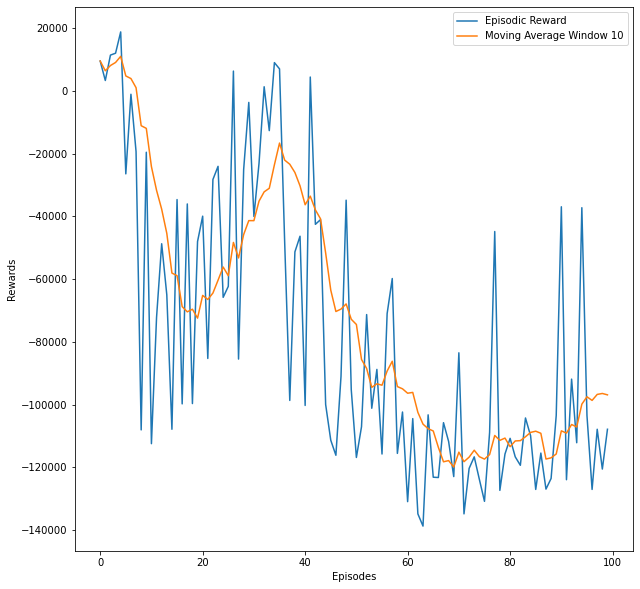

In [53]:
machine1 = Machine_env()
pol = policy_estimator(machine1)

#Parameters
episodes = 100
batchsize = 20
gamma = 0.85
lr = 0.05


#writer = SummaryWriter(f"runs/gamma/lr_{lr}gamma_{gamma}episode_{episodes}batch_{batchsize}_mu0_{mu0}_no_entropy_reg")

results = reinforce(machine1,pol,episodes,batchsize,gamma,lr)
rewards = results[0]
actions = np.array(results[1])
states = results[2]

episode = [i for i in range(episodes)]

#Moving average we will use a window size of 50

moving_averages = []
window_size = 10

df = pd.DataFrame(rewards,columns = ['r'])
moving_ave = df.r.rolling(window_size,min_periods=1).mean().values

fig = plt.figure(figsize=(10,10))
plt.plot(episode,rewards,label = 'Episodic Reward')
plt.plot(episode,moving_ave,label = f'Moving Average Window {window_size}')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.show()

# Entropy Regularised

In [77]:
def reinforce_entropy_regularised(machine,policy_estimator,num_episodes,batch_size,gamma,lr,entropy_coeff): #Learning algo
    # Set up lists to hold results
    # Set up lists to hold results
    total_rewards = [] #Total actual reward for each episode
    batch_rewards = []  #Discounted expected future rewards for each batch
    batch_actions = []
    batch_observation = []
    state_seq = []
    
    # Define optimizer
    optimizer = torch.optim.Adam(policy_estimator.network.parameters(),lr=lr)
    
    action_space = machine.action_space
    
    for ep in range(num_episodes):
        machine.reset()
        observation = []
        rewards = []
        actions = []
        
        while(not machine.done):
            obs = machine.sensor(machine.state).tolist() #observation
            
            action_probs = policy_estimator.predict(obs).detach().numpy() #convert to numpy and get action prob
            action = np.random.choice(action_space, p=action_probs) #select weighted actions based on NN output prob
            print(f"Action prob: {action_probs}, Action: {action}, state: {machine.state}")
            
            r = machine.step(action) #receive reward and update machine to the next state after doing the sampled action
            
            observation.append(obs)
            rewards.append(r)
            actions.append(action)
        
        discount_r = normalized_discount_reward(rewards,gamma) #normalised already
        
        total_rewards.append(sum(rewards)) #Cumulative reward for this episode
        
        #After batch complete time,store the parameters
        batch_rewards.append(discount_r)
        batch_observation.append(observation)
        batch_actions.append(actions)
        state_seq.append(machine.state_seq)
        
        #update policy
        obs_tensor = torch.FloatTensor(observation)
        action_tensor = torch.LongTensor(actions)
        reward_tensor = torch.from_numpy(np.array(discount_r).copy()) #resolve stride problem


        #Calculate loss Ver 3
        logprob = torch.log(policy_estimator.predict(obs_tensor))
#         print(logprob)
#         print(logprob[np.arange(len(action_tensor)), action_tensor])
        selected_logprobs = reward_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
        #print(selected_logprobs)
        
        #Entropy
        prob = policy_estimator.predict(obs_tensor)
        ave_entropy = entropy(prob,entropy_coeff)
        
        loss = -selected_logprobs.mean() - ave_entropy
        
        print(f"Reward for this episode {total_rewards[-1]}, loss is {loss}")
        
        optimizer.zero_grad()
        # Calculate gradients
        loss.backward()
        # Apply gradients
        optimizer.step()
        
#         #Tensorboard params
#         writer.add_scalar("Loss", loss, ep)
#         writer.add_scalar('Rewards',sum(rewards),ep)
#         for name, weight in policy_estimator.network.named_parameters():
#             writer.add_histogram(name,weight, ep)
#             if weight.grad != None:
#                 writer.add_histogram(f"{name}.grad",weight.grad, ep)
    
#     writer.add_graph(policy_estimator.network,torch.FloatTensor(machine.sensor(0))) #draw graph
#     writer.flush()
#     writer.close()
    
    return (total_rewards,batch_actions,state_seq)

C:\Users\overl\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Action prob: [0.4615343 0.5384657], Action: 0, state: 0
Action prob: [0.46223822 0.5377618 ], Action: 1, state: 0
Action prob: [0.4150416 0.5849583], Action: 0, state: 4
Action prob: [0.46142536 0.53857464], Action: 0, state: 0
Action prob: [0.4534665 0.5465336], Action: 1, state: 1
Action prob: [0.4150416 0.5849583], Action: 1, state: 5
Action prob: [0.46496356 0.5350364 ], Action: 1, state: 0
Action prob: [0.4150416 0.5849583], Action: 1, state: 4
Action prob: [0.4150416 0.5849583], Action: 1, state: 4
Action prob: [0.4579341 0.5420659], Action: 1, state: 0
Action prob: [0.4150416 0.5849583], Action: 1, state: 4
Action prob: [0.45811212 0.5418878 ], Action: 0, state: 0
Action prob: [0.46233344 0.5376666 ], Action: 0, state: 1
Action prob: [0.46278587 0.5372141 ], Action: 1, state: 2
Action prob: [0.4150416 0.5849583], Action: 1, state: 6
Action prob: [0.46756187 0.5324381 ], Action: 0, state: 1
Action prob: [0.46065444 0.5393455 ], Action: 0, state: 2
Action prob: [0.4666738  0.53332

Action prob: [0.6445046  0.35549536], Action: 1, state: 3
Action prob: [0.5818573  0.41814265], Action: 0, state: 7
Action prob: [0.64440966 0.35559028], Action: 0, state: 2
Action prob: [0.6427652  0.35723475], Action: 1, state: 2
Action prob: [0.5818573  0.41814265], Action: 0, state: 6
Action prob: [0.64219266 0.3578074 ], Action: 1, state: 1
Action prob: [0.5818573  0.41814265], Action: 1, state: 5
Action prob: [0.5818573  0.41814265], Action: 0, state: 5
Action prob: [0.5818573  0.41814265], Action: 1, state: 5
Action prob: [0.5818573  0.41814265], Action: 0, state: 5
Reward for this episode 6100, loss is -0.06303773405224973
Action prob: [0.66949046 0.33050963], Action: 1, state: 0
Action prob: [0.5974966  0.40250337], Action: 1, state: 4
Action prob: [0.5974966  0.40250337], Action: 1, state: 4
Action prob: [0.682806   0.31719398], Action: 0, state: 0
Action prob: [0.6820419  0.31795812], Action: 0, state: 0
Action prob: [0.6741501  0.32584995], Action: 0, state: 0
Action prob: 

Action prob: [0.75518805 0.24481197], Action: 0, state: 2
Action prob: [0.756815   0.24318501], Action: 0, state: 3
Action prob: [0.7260513 0.2739488], Action: 0, state: 8
Action prob: [0.7838412  0.21615882], Action: 1, state: 8
Action prob: [0.7343059  0.26569408], Action: 0, state: 8
Action prob: [0.7314484  0.26855162], Action: 0, state: 8
Action prob: [0.7814168  0.21858324], Action: 0, state: 8
Action prob: [0.78078246 0.21921752], Action: 0, state: 8
Action prob: [0.7835484  0.21645166], Action: 0, state: 8
Action prob: [0.7560559  0.24394406], Action: 0, state: 8
Action prob: [0.730089 0.269911], Action: 1, state: 8
Action prob: [0.7610287  0.23897125], Action: 0, state: 8
Action prob: [0.7580414  0.24195859], Action: 0, state: 8
Action prob: [0.7678102  0.23218979], Action: 0, state: 8
Action prob: [0.75469464 0.24530537], Action: 1, state: 8
Action prob: [0.75763017 0.2423698 ], Action: 1, state: 8
Action prob: [0.7281807 0.2718193], Action: 1, state: 8
Reward for this episod

Action prob: [0.81328875 0.18671131], Action: 0, state: 8
Action prob: [0.8274154  0.17258456], Action: 1, state: 8
Action prob: [0.7840366  0.21596341], Action: 0, state: 8
Action prob: [0.83433896 0.16566111], Action: 0, state: 8
Action prob: [0.7784653  0.22153476], Action: 0, state: 8
Action prob: [0.83423096 0.165769  ], Action: 0, state: 8
Action prob: [0.8220647 0.1779353], Action: 0, state: 8
Action prob: [0.82412845 0.1758716 ], Action: 0, state: 8
Action prob: [0.82136923 0.17863077], Action: 0, state: 8
Action prob: [0.8321917 0.1678083], Action: 0, state: 8
Action prob: [0.83748007 0.16251993], Action: 0, state: 8
Action prob: [0.82203335 0.17796662], Action: 1, state: 8
Action prob: [0.82791305 0.17208694], Action: 0, state: 8
Action prob: [0.8084532  0.19154681], Action: 0, state: 8
Action prob: [0.84374    0.15626003], Action: 0, state: 8
Reward for this episode -91300, loss is 0.02493903779489678
Action prob: [0.8095774  0.19042255], Action: 0, state: 0
Action prob: [0.

Action prob: [0.8547701  0.14522988], Action: 0, state: 9
Action prob: [0.8218496 0.1781504], Action: 0, state: 9
Action prob: [0.8132692  0.18673082], Action: 0, state: 9
Action prob: [0.8663796  0.13362044], Action: 0, state: 9
Action prob: [0.8389516  0.16104838], Action: 0, state: 9
Action prob: [0.86713874 0.1328613 ], Action: 0, state: 9
Action prob: [0.84972256 0.15027747], Action: 0, state: 9
Action prob: [0.82345796 0.17654204], Action: 1, state: 9
Action prob: [0.8591732  0.14082679], Action: 0, state: 9
Action prob: [0.87287825 0.1271217 ], Action: 0, state: 9
Action prob: [0.81832033 0.1816797 ], Action: 0, state: 9
Action prob: [0.8701974  0.12980257], Action: 0, state: 9
Action prob: [0.82144517 0.17855477], Action: 0, state: 9
Action prob: [0.86745095 0.13254903], Action: 1, state: 9
Action prob: [0.85948247 0.14051759], Action: 0, state: 9
Action prob: [0.86568457 0.13431546], Action: 0, state: 9
Action prob: [0.848444   0.15155599], Action: 0, state: 9
Reward for this 

Action prob: [0.80866534 0.19133465], Action: 0, state: 8
Action prob: [0.87551    0.12448999], Action: 0, state: 8
Action prob: [0.8894114  0.11058863], Action: 0, state: 8
Reward for this episode -40700, loss is -0.005236349085091734
Action prob: [0.86859137 0.13140859], Action: 0, state: 0
Action prob: [0.8643074 0.1356926], Action: 0, state: 1
Action prob: [0.86757565 0.13242435], Action: 0, state: 1
Action prob: [0.8680572  0.13194281], Action: 0, state: 2
Action prob: [0.871663   0.12833704], Action: 0, state: 3
Action prob: [0.86571974 0.13428025], Action: 0, state: 3
Action prob: [0.87006354 0.12993649], Action: 0, state: 3
Action prob: [0.8812337  0.11876627], Action: 0, state: 3
Action prob: [0.872927   0.12707298], Action: 0, state: 3
Action prob: [0.8614194  0.13858056], Action: 0, state: 3
Action prob: [0.88841224 0.1115877 ], Action: 0, state: 8
Action prob: [0.8860684 0.1139316], Action: 0, state: 8
Action prob: [0.9078782  0.09212176], Action: 0, state: 8
Action prob: [

Action prob: [0.89614075 0.10385921], Action: 0, state: 8
Action prob: [0.9171392  0.08286078], Action: 0, state: 8
Reward for this episode -86000, loss is -0.0871622815294742
Action prob: [0.88190305 0.11809696], Action: 0, state: 0
Action prob: [0.8850044  0.11499558], Action: 0, state: 0
Action prob: [0.88844794 0.11155207], Action: 1, state: 1
Action prob: [0.48609877 0.51390123], Action: 0, state: 5
Action prob: [0.48609877 0.51390123], Action: 0, state: 5
Action prob: [0.8858865  0.11411349], Action: 0, state: 0
Action prob: [0.8902503  0.10974965], Action: 0, state: 0
Action prob: [0.89312893 0.10687106], Action: 0, state: 1
Action prob: [0.8905277  0.10947227], Action: 0, state: 1
Action prob: [0.8880617  0.11193823], Action: 0, state: 1
Action prob: [0.8893767 0.1106233], Action: 0, state: 1
Action prob: [0.8909081  0.10909192], Action: 0, state: 1
Action prob: [0.88662046 0.11337952], Action: 0, state: 2
Action prob: [0.881099   0.11890095], Action: 0, state: 2
Action prob: [

Action prob: [0.86787766 0.13212231], Action: 0, state: 8
Action prob: [0.9132046  0.08679545], Action: 0, state: 8
Action prob: [0.8789328  0.12106724], Action: 0, state: 8
Action prob: [0.8790019  0.12099811], Action: 0, state: 8
Action prob: [0.9151701 0.0848299], Action: 0, state: 8
Action prob: [0.91563064 0.0843693 ], Action: 0, state: 8
Action prob: [0.91629016 0.08370982], Action: 0, state: 8
Action prob: [0.880076   0.11992406], Action: 0, state: 8
Action prob: [0.8748117  0.12518829], Action: 0, state: 8
Action prob: [0.8779517  0.12204834], Action: 0, state: 8
Action prob: [0.8973716  0.10262842], Action: 0, state: 8
Action prob: [0.8698508  0.13014926], Action: 0, state: 8
Action prob: [0.9154501  0.08454987], Action: 0, state: 8
Action prob: [0.8707391  0.12926088], Action: 0, state: 8
Reward for this episode -58600, loss is -0.003854362623120845
Action prob: [0.90165514 0.09834493], Action: 0, state: 0
Action prob: [0.8996688  0.10033121], Action: 0, state: 0
Action prob:

Action prob: [0.9247096  0.07529039], Action: 0, state: 9
Action prob: [0.8845755  0.11542453], Action: 0, state: 9
Action prob: [0.9387768 0.0612232], Action: 1, state: 9
Action prob: [0.92125934 0.07874063], Action: 0, state: 9
Action prob: [0.9207335  0.07926647], Action: 0, state: 9
Action prob: [0.9284205  0.07157943], Action: 1, state: 9
Reward for this episode -14300, loss is -0.1581989112440043
Action prob: [0.909335   0.09066499], Action: 0, state: 0
Action prob: [0.91446114 0.08553886], Action: 0, state: 0
Action prob: [0.9153806  0.08461948], Action: 0, state: 0
Action prob: [0.91095    0.08904994], Action: 1, state: 0
Action prob: [0.4887372  0.51126283], Action: 1, state: 4
Action prob: [0.9039916  0.09600839], Action: 0, state: 0
Action prob: [0.90492994 0.0950701 ], Action: 0, state: 0
Action prob: [0.91495967 0.08504041], Action: 0, state: 0
Action prob: [0.9059099  0.09409007], Action: 0, state: 1
Action prob: [0.9118841  0.08811588], Action: 0, state: 1
Action prob: [

Action prob: [0.9105639  0.08943616], Action: 0, state: 2
Action prob: [0.91353726 0.08646273], Action: 0, state: 3
Action prob: [0.9319943  0.06800568], Action: 0, state: 3
Action prob: [0.901727   0.09827293], Action: 0, state: 3
Action prob: [0.92405385 0.07594611], Action: 0, state: 3
Action prob: [0.9103141  0.08968589], Action: 0, state: 3
Action prob: [0.9122369  0.08776311], Action: 0, state: 3
Action prob: [0.9048136  0.09518642], Action: 0, state: 3
Action prob: [0.90667933 0.09332065], Action: 0, state: 3
Action prob: [0.9183613  0.08163869], Action: 0, state: 3
Action prob: [0.92867255 0.07132747], Action: 0, state: 3
Action prob: [0.90783495 0.0921651 ], Action: 0, state: 3
Action prob: [0.917068   0.08293205], Action: 0, state: 3
Action prob: [0.89495784 0.10504214], Action: 0, state: 8
Action prob: [0.9283869  0.07161304], Action: 0, state: 8
Action prob: [0.93402576 0.06597419], Action: 0, state: 8
Action prob: [0.9332898  0.06671009], Action: 0, state: 8
Action prob: [

Action prob: [0.8921404  0.10785957], Action: 0, state: 8
Action prob: [0.9394144  0.06058554], Action: 0, state: 8
Action prob: [0.85182834 0.1481716 ], Action: 0, state: 8
Action prob: [0.9381846 0.0618154], Action: 0, state: 8
Action prob: [0.9185148  0.08148524], Action: 0, state: 8
Action prob: [0.9018712  0.09812883], Action: 0, state: 8
Action prob: [0.89978004 0.10022   ], Action: 0, state: 8
Action prob: [0.93125963 0.06874042], Action: 0, state: 8
Action prob: [0.93633986 0.06366016], Action: 0, state: 8
Action prob: [0.93601954 0.06398047], Action: 0, state: 8
Action prob: [0.936122   0.06387801], Action: 0, state: 8
Action prob: [0.92935157 0.07064839], Action: 0, state: 8
Action prob: [0.9477536  0.05224639], Action: 0, state: 8
Action prob: [0.9267985  0.07320153], Action: 0, state: 8
Action prob: [0.9347363 0.0652637], Action: 0, state: 8
Action prob: [0.9264324  0.07356767], Action: 0, state: 8
Action prob: [0.94150054 0.0584995 ], Action: 0, state: 8
Action prob: [0.89

Action prob: [0.92871964 0.0712804 ], Action: 0, state: 8
Action prob: [0.92030865 0.07969136], Action: 0, state: 8
Action prob: [0.9576335  0.04236647], Action: 0, state: 8
Action prob: [0.916034   0.08396598], Action: 1, state: 8
Action prob: [0.9460261  0.05397398], Action: 0, state: 8
Action prob: [0.9106484  0.08935158], Action: 0, state: 8
Action prob: [0.9444816  0.05551835], Action: 0, state: 8
Action prob: [0.93985885 0.06014108], Action: 1, state: 8
Action prob: [0.9572164  0.04278357], Action: 0, state: 8
Action prob: [0.9230258  0.07697425], Action: 0, state: 8
Action prob: [0.9410122 0.0589878], Action: 0, state: 8
Action prob: [0.9120453  0.08795463], Action: 0, state: 8
Action prob: [0.9408439  0.05915614], Action: 0, state: 8
Action prob: [0.9134235  0.08657648], Action: 0, state: 8
Action prob: [0.94593793 0.05406203], Action: 0, state: 8
Action prob: [0.91058373 0.08941624], Action: 0, state: 8
Reward for this episode -29900, loss is -0.08806525791710317
Action prob: 

Action prob: [0.94929236 0.05070769], Action: 0, state: 0
Action prob: [0.93762887 0.06237118], Action: 0, state: 1
Action prob: [0.9419688  0.05803123], Action: 0, state: 1
Action prob: [0.9447099  0.05529018], Action: 0, state: 1
Action prob: [0.93719476 0.06280527], Action: 0, state: 1
Action prob: [0.94946516 0.0505349 ], Action: 0, state: 1
Action prob: [0.942326   0.05767393], Action: 0, state: 1
Action prob: [0.9415444  0.05845558], Action: 0, state: 2
Action prob: [0.940203   0.05979694], Action: 0, state: 3
Action prob: [0.93588537 0.06411461], Action: 0, state: 3
Action prob: [0.95915616 0.04084384], Action: 0, state: 3
Action prob: [0.95239407 0.04760595], Action: 0, state: 8
Action prob: [0.95767075 0.04232923], Action: 0, state: 8
Action prob: [0.95913893 0.04086109], Action: 0, state: 8
Action prob: [0.92535144 0.07464857], Action: 0, state: 8
Action prob: [0.9544241  0.04557586], Action: 0, state: 8
Action prob: [0.95344347 0.04655657], Action: 0, state: 8
Action prob: [

Action prob: [0.9527095  0.04729052], Action: 0, state: 1
Action prob: [0.9559176 0.0440824], Action: 0, state: 2
Action prob: [0.9539493  0.04605076], Action: 0, state: 3
Action prob: [0.9536874  0.04631258], Action: 0, state: 3
Action prob: [0.9527935  0.04720649], Action: 0, state: 3
Action prob: [0.9526872  0.04731284], Action: 0, state: 3
Action prob: [0.93783295 0.06216703], Action: 1, state: 3
Action prob: [0.52502686 0.4749732 ], Action: 0, state: 7
Action prob: [0.9514419  0.04855813], Action: 0, state: 2
Action prob: [0.9528758 0.0471242], Action: 0, state: 2
Action prob: [0.9497753  0.05022476], Action: 0, state: 2
Action prob: [0.9640077  0.03599235], Action: 0, state: 3
Action prob: [0.9534869  0.04651306], Action: 0, state: 3
Action prob: [0.9628963  0.03710374], Action: 0, state: 3
Action prob: [0.96641356 0.03358646], Action: 0, state: 8
Action prob: [0.9631069  0.03689311], Action: 0, state: 8
Action prob: [0.9691574  0.03084258], Action: 0, state: 8
Action prob: [0.93

Action prob: [0.96962804 0.03037201], Action: 0, state: 8
Action prob: [0.9439136  0.05608646], Action: 0, state: 8
Action prob: [0.9446089  0.05539105], Action: 0, state: 8
Action prob: [0.9413497 0.0586503], Action: 0, state: 8
Action prob: [0.9673093  0.03269073], Action: 0, state: 8
Action prob: [0.9427063  0.05729366], Action: 0, state: 8
Action prob: [0.96655387 0.0334461 ], Action: 0, state: 8
Action prob: [0.9727216  0.02727835], Action: 0, state: 8
Action prob: [0.9682151  0.03178493], Action: 0, state: 8
Reward for this episode -111500, loss is -0.17109360281285124
Action prob: [0.95722085 0.0427791 ], Action: 0, state: 0
Action prob: [0.96349305 0.03650695], Action: 0, state: 0
Action prob: [0.958806   0.04119401], Action: 0, state: 0
Action prob: [0.96054417 0.03945588], Action: 0, state: 0
Action prob: [0.95739055 0.04260951], Action: 0, state: 0
Action prob: [0.9611126  0.03888744], Action: 0, state: 0
Action prob: [0.9586193  0.04138075], Action: 0, state: 0
Action prob:

Action prob: [0.97088844 0.02911156], Action: 0, state: 8
Action prob: [0.9707254  0.02927455], Action: 0, state: 8
Action prob: [0.9711421  0.02885794], Action: 0, state: 8
Action prob: [0.95343727 0.04656275], Action: 0, state: 8
Action prob: [0.9536935  0.04630654], Action: 0, state: 8
Action prob: [0.9815059  0.01849413], Action: 0, state: 8
Action prob: [0.9635754  0.03642457], Action: 0, state: 8
Action prob: [0.9762339  0.02376608], Action: 0, state: 8
Action prob: [0.9738733  0.02612662], Action: 0, state: 8
Action prob: [0.9638892 0.0361108], Action: 0, state: 8
Reward for this episode -128300, loss is -0.025173247650255665
Action prob: [0.9634644  0.03653561], Action: 0, state: 0
Action prob: [0.960667   0.03933297], Action: 0, state: 1
Action prob: [0.96073693 0.03926311], Action: 0, state: 2
Action prob: [0.9597595  0.04024046], Action: 0, state: 2
Action prob: [0.9625673  0.03743262], Action: 0, state: 2
Action prob: [0.97045386 0.02954612], Action: 0, state: 3
Action prob

Action prob: [0.95862156 0.04137845], Action: 0, state: 1
Action prob: [0.9605175  0.03948243], Action: 0, state: 1
Action prob: [0.9594582  0.04054181], Action: 0, state: 1
Action prob: [0.9572792  0.04272084], Action: 0, state: 2
Action prob: [0.9362831  0.06371683], Action: 0, state: 3
Action prob: [0.96744746 0.03255256], Action: 0, state: 8
Action prob: [0.94692034 0.05307966], Action: 0, state: 8
Action prob: [0.9428421  0.05715783], Action: 0, state: 8
Action prob: [0.9673708 0.0326292], Action: 0, state: 8
Action prob: [0.94611305 0.05388694], Action: 0, state: 8
Action prob: [0.9714659  0.02853408], Action: 0, state: 8
Action prob: [0.9693443  0.03065563], Action: 0, state: 8
Action prob: [0.9713741  0.02862591], Action: 0, state: 8
Action prob: [0.9470314  0.05296864], Action: 0, state: 8
Action prob: [0.9474498  0.05255013], Action: 0, state: 8
Action prob: [0.9674548  0.03254518], Action: 0, state: 8
Action prob: [0.9401044  0.05989556], Action: 0, state: 8
Action prob: [0.

Action prob: [0.95624036 0.04375966], Action: 0, state: 2
Action prob: [0.95544213 0.04455791], Action: 0, state: 3
Action prob: [0.95927525 0.04072476], Action: 0, state: 3
Action prob: [0.9495686 0.0504314], Action: 0, state: 3
Action prob: [0.95394945 0.04605053], Action: 0, state: 3
Action prob: [0.94017637 0.05982362], Action: 0, state: 3
Action prob: [0.943778   0.05622205], Action: 0, state: 3
Action prob: [0.96624136 0.03375863], Action: 0, state: 3
Action prob: [0.95668495 0.04331505], Action: 0, state: 3
Action prob: [0.9665639  0.03343615], Action: 0, state: 3
Action prob: [0.9356819 0.0643181], Action: 0, state: 3
Action prob: [0.9625636  0.03743637], Action: 0, state: 8
Action prob: [0.9599805  0.04001946], Action: 0, state: 8
Action prob: [0.9755096  0.02449045], Action: 0, state: 8
Action prob: [0.9699421  0.03005791], Action: 0, state: 8
Action prob: [0.9439299  0.05607002], Action: 0, state: 8
Action prob: [0.96467084 0.0353291 ], Action: 0, state: 8
Action prob: [0.96

Action prob: [0.9441804  0.05581952], Action: 0, state: 8
Action prob: [0.96746475 0.03253533], Action: 0, state: 8
Action prob: [0.96173406 0.03826595], Action: 0, state: 8
Action prob: [0.9612493  0.03875074], Action: 0, state: 8
Action prob: [0.9634787  0.03652132], Action: 0, state: 8
Action prob: [0.9312427  0.06875732], Action: 1, state: 8
Reward for this episode -111200, loss is 0.006691933623446139
Action prob: [0.95597667 0.04402339], Action: 0, state: 0
Action prob: [0.9467613  0.05323872], Action: 0, state: 0
Action prob: [0.952012   0.04798798], Action: 0, state: 0
Action prob: [0.94396305 0.05603696], Action: 0, state: 1
Action prob: [0.956053   0.04394697], Action: 0, state: 1
Action prob: [0.9469825  0.05301743], Action: 0, state: 1
Action prob: [0.95008624 0.0499137 ], Action: 0, state: 2
Action prob: [0.94656676 0.05343325], Action: 0, state: 2
Action prob: [0.9383964  0.06160364], Action: 0, state: 3
Action prob: [0.94982433 0.0501757 ], Action: 0, state: 3
Action pro

Action prob: [0.9513713  0.04862872], Action: 0, state: 8
Action prob: [0.90917474 0.09082528], Action: 0, state: 8
Action prob: [0.9432942 0.0567058], Action: 0, state: 8
Action prob: [0.92345136 0.07654863], Action: 0, state: 8
Action prob: [0.9334014  0.06659865], Action: 0, state: 8
Action prob: [0.94103223 0.05896781], Action: 0, state: 8
Action prob: [0.8987029  0.10129708], Action: 0, state: 8
Action prob: [0.94184875 0.05815127], Action: 0, state: 8
Action prob: [0.9384566  0.06154346], Action: 0, state: 8
Action prob: [0.9525022  0.04749781], Action: 0, state: 8
Action prob: [0.94064647 0.0593535 ], Action: 0, state: 8
Action prob: [0.9418773  0.05812264], Action: 0, state: 8
Action prob: [0.90745044 0.09254953], Action: 0, state: 8
Action prob: [0.9443569  0.05564312], Action: 0, state: 8
Action prob: [0.90873146 0.09126861], Action: 0, state: 8
Action prob: [0.95093095 0.04906905], Action: 0, state: 8
Action prob: [0.93797606 0.06202393], Action: 0, state: 8
Action prob: [0.

Action prob: [0.9172341  0.08276588], Action: 0, state: 2
Action prob: [0.91335934 0.08664073], Action: 0, state: 2
Action prob: [0.9133835  0.08661656], Action: 0, state: 3
Action prob: [0.93303365 0.06696635], Action: 0, state: 3
Action prob: [0.9143252  0.08567479], Action: 0, state: 3
Action prob: [0.917286   0.08271401], Action: 0, state: 3
Action prob: [0.9050195  0.09498041], Action: 0, state: 3
Action prob: [0.8823961  0.11760387], Action: 0, state: 8
Action prob: [0.93215173 0.06784828], Action: 0, state: 8
Action prob: [0.9257464  0.07425362], Action: 0, state: 8
Action prob: [0.93175304 0.06824695], Action: 0, state: 8
Action prob: [0.8936274  0.10637267], Action: 0, state: 8
Action prob: [0.88563603 0.11436393], Action: 0, state: 8
Action prob: [0.8913253  0.10867476], Action: 0, state: 8
Action prob: [0.88304913 0.11695087], Action: 0, state: 8
Action prob: [0.92253125 0.07746872], Action: 0, state: 8
Action prob: [0.9288535  0.07114646], Action: 1, state: 8
Action prob: [

Action prob: [0.89865303 0.10134695], Action: 0, state: 1
Action prob: [0.9028893  0.09711076], Action: 0, state: 2
Action prob: [0.8967421 0.1032579], Action: 0, state: 3
Action prob: [0.8995887  0.10041134], Action: 0, state: 3
Action prob: [0.9210895  0.07891053], Action: 0, state: 3
Action prob: [0.92348844 0.0765116 ], Action: 0, state: 8
Action prob: [0.91671455 0.08328552], Action: 0, state: 8
Action prob: [0.8842285  0.11577151], Action: 0, state: 8
Action prob: [0.92676336 0.07323667], Action: 0, state: 8
Action prob: [0.8904661  0.10953395], Action: 0, state: 8
Action prob: [0.8977008  0.10229924], Action: 0, state: 8
Action prob: [0.8961671  0.10383295], Action: 0, state: 8
Action prob: [0.91864294 0.08135712], Action: 0, state: 8
Action prob: [0.8826219 0.1173781], Action: 0, state: 8
Action prob: [0.8988983  0.10110167], Action: 0, state: 8
Action prob: [0.91921854 0.08078147], Action: 0, state: 8
Action prob: [0.9290047  0.07099529], Action: 0, state: 8
Action prob: [0.91

Action prob: [0.90844625 0.09155381], Action: 0, state: 8
Action prob: [0.85210276 0.14789724], Action: 0, state: 8
Action prob: [0.8699594  0.13004054], Action: 0, state: 8
Action prob: [0.85335416 0.14664578], Action: 0, state: 8
Action prob: [0.8525151  0.14748488], Action: 0, state: 8
Action prob: [0.91416216 0.08583787], Action: 0, state: 8
Action prob: [0.88959134 0.11040866], Action: 0, state: 8
Action prob: [0.9063974  0.09360263], Action: 1, state: 8
Action prob: [0.9177624  0.08223756], Action: 0, state: 8
Action prob: [0.86146665 0.13853334], Action: 0, state: 8
Action prob: [0.8545939  0.14540611], Action: 0, state: 8
Action prob: [0.8593829  0.14061707], Action: 0, state: 8
Action prob: [0.85484016 0.14515981], Action: 0, state: 8
Action prob: [0.91191596 0.08808409], Action: 0, state: 8
Action prob: [0.8966308  0.10336917], Action: 0, state: 8
Action prob: [0.9046315  0.09536847], Action: 0, state: 8
Reward for this episode -73500, loss is 0.08113958629506401
Action prob:

Action prob: [0.8342569  0.16574317], Action: 1, state: 0
Action prob: [0.54688823 0.45311183], Action: 0, state: 4
Action prob: [0.8323728  0.16762722], Action: 1, state: 0
Action prob: [0.54688823 0.45311183], Action: 1, state: 4
Action prob: [0.54688823 0.45311183], Action: 1, state: 4
Action prob: [0.8227956  0.17720436], Action: 0, state: 0
Action prob: [0.8234804  0.17651962], Action: 1, state: 0
Action prob: [0.54688823 0.45311183], Action: 0, state: 4
Action prob: [0.54688823 0.45311183], Action: 1, state: 4
Action prob: [0.8289602  0.17103982], Action: 0, state: 0
Action prob: [0.82933664 0.17066336], Action: 1, state: 1
Action prob: [0.54688823 0.45311183], Action: 0, state: 5
Action prob: [0.83831805 0.16168192], Action: 0, state: 0
Action prob: [0.8362256  0.16377437], Action: 0, state: 0
Action prob: [0.83145684 0.16854316], Action: 0, state: 1
Action prob: [0.8364826  0.16351742], Action: 0, state: 2
Action prob: [0.8356802 0.1643198], Action: 0, state: 2
Action prob: [0.

<ipython-input-78-d3c55bf3464c>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  actions = np.array(results[1])


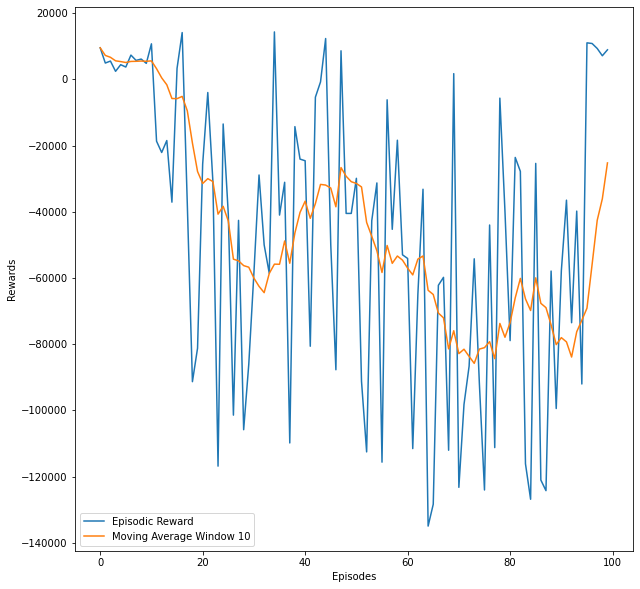

In [78]:
machine1 = Machine_env()
pol = policy_estimator(machine1)

#Parameters
episodes = 100
gamma = 0.8
lr= 0.01
entropy_coeff = 0.01


#writer = SummaryWriter(f"runs/entropy/lr_{lr}gamma_{gamma}episode_{episodes}_mu_{mu0}_entropy_reg_{entropy_coeff}")

results = reinforce_entropy_regularised(machine1,pol,episodes,batchsize,gamma,lr,entropy_coeff)
rewards = results[0]
actions = np.array(results[1])
states = results[2]

episode = [i for i in range(episodes)]

#Moving average we will use a window size of 50

moving_averages = []
window_size = 10

df = pd.DataFrame(rewards,columns = ['r'])
moving_ave = df.r.rolling(window_size,min_periods=1).mean().values

fig = plt.figure(figsize=(10,10))
plt.plot(episode,rewards,label = 'Episodic Reward')
plt.plot(episode,moving_ave,label = f'Moving Average Window {window_size}')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.show()

# Baseline Case

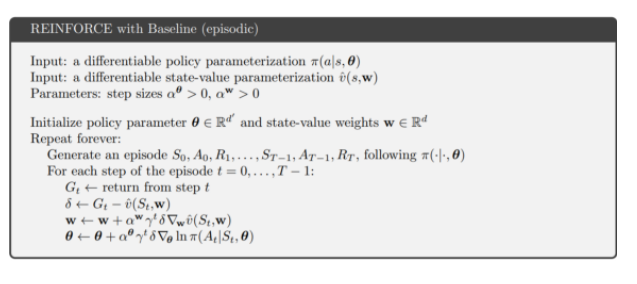

In [5]:
import torch.nn.functional as F

class policy_estimator(nn.Module): #neural network
    def __init__(self, env):
        super(policy_estimator, self).__init__()
        self.n_inputs = env.observation_space
        self.n_outputs = len(env.action_space)
        
        self.layer1 = nn.Linear(env.observation_space,128)
        
        self.layer2 = nn.Linear(128,len(env.action_space))
        
            
    
    def forward(self, x):#prediction is raw value
        x = torch.FloatTensor(x)
    
        x = self.layer1(x)
        x  = F.relu(x)
        x = self.layer2(x)

        return F.softmax(x,dim = -1)

class StateValueNetwork(nn.Module):
    
    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()
        
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, x):
        #input layer
        x = self.input_layer(x)
        
        #activiation relu
        x = F.relu(x)
        
        #get state value
        state_value = self.output_layer(x)
        
        return state_value
    
def train_value(G, state_vals, optimizer):
    ''' Update state-value network parameters
    Args:
    - G (Array): trajectory of cumulative discounted rewards 
    - state_vals (Array): trajectory of predicted state-value at each step
    - optimizer (Pytorch optimizer): optimizer to update state-value network parameters
    '''
    
    G = G.to(torch.float32)
    state_vals = state_vals.to(torch.float32)
    #calculate MSE loss
    val_loss = F.mse_loss(state_vals, G)
        
    #Backpropagate
    optimizer.zero_grad()
    val_loss.backward()
    optimizer.step()
    

def stack_state_value(states,stateval_network): #input is a list of observations/states that will be used to train the nn for statevalue network
    state_vals = []
    for state in states:
        state = torch.from_numpy(state).float().unsqueeze(0)
        state_vals.append(stateval_network(state))
    return torch.stack(state_vals).squeeze()
    
    


In [11]:
def reinforce_baseline(machine,baseline_net,policy_estimator,num_episodes,gamma,lr): #Learning algo
    # Set up lists to hold results
    # Set up lists to hold results
    total_rewards = [] #Total actual reward for each episode
    batch_rewards = []  #Discounted expected future rewards for each batch
    batch_actions = []
    batch_observation = []
    state_seq = []
    
    # Define optimizer
    optimizer = torch.optim.Adam(policy_estimator.parameters(),lr=lr)
    state_val_optimizer = torch.optim.Adam(baseline_net.parameters(),lr=0.01)
    
    action_space = machine.action_space
    
    for ep in range(num_episodes):
        machine.reset()
        observation = []
        rewards = []
        actions = []
        
        while(not machine.done):
            obs = machine.sensor(machine.state).tolist() #observation
            
            action_probs = policy_estimator(obs).detach().numpy() #convert to numpy and get action prob
            print(action_probs)
            action = np.random.choice(action_space, p=action_probs) #select weighted actions based on NN output prob
            print(f"Action prob: {action_probs}, Action: {action}, state: {machine.state}")
            
            r = machine.step(action) #receive reward and update machine to the next state after doing the sampled action
            
            observation.append(obs)
            rewards.append(r)
            actions.append(action)
        
        discount_r = normalized_discount_reward(rewards,gamma) #normalised future rewards
        
        total_rewards.append(sum(rewards)) #Cumulative reward for this episode
        
        #After batch complete time,store the parameters
        batch_rewards.append(discount_r)
        batch_observation.append(observation)
        batch_actions.append(actions)
        state_seq.append(machine.state_seq)
        
        print(actions)
        obs_tensor = torch.FloatTensor(observation)
        action_tensor = torch.LongTensor(actions)
        reward_tensor = torch.from_numpy(np.array(discount_r).copy()) #discounted reward G
        
        #calculate state values 
        state_value_tensor = stack_state_value(np.array(observation),baseline_net)
        
        #train state value network
        train_value(reward_tensor,state_value_tensor,state_val_optimizer)
        
        #calculate delta or advantage 
        deltas = [gt - val for gt, val in zip(reward_tensor, state_value_tensor)]
        deltas = torch.tensor(deltas)

        
        #update policy
        logprob = torch.log(policy_estimator(obs_tensor))
#         print(logprob)
#         print(action_tensor)
        #print(logprob[np.arange(len(action_tensor)), action_tensor])
        selected_logprobs = deltas * logprob[np.arange(len(action_tensor)), action_tensor]
        print(selected_logprobs)
        
        
        loss = -selected_logprobs.mean()
        
        print(f"Reward for this episode {total_rewards[-1]}, loss is {loss}")
        
        optimizer.zero_grad()
        # Calculate gradients
        loss.backward()
        # Apply gradients
        optimizer.step()
        
        #Tensorboard params
#         writer.add_scalar("Loss", loss, ep)
#         writer.add_scalar('Rewards',sum(rewards),ep)
#         for name, weight in policy_estimator.named_parameters():
#             try:
#                 writer.add_histogram(name,weight, ep)
#             except:
#                 continue
#             if weight.grad != None:
#                 writer.add_histogram(f"{name}.grad",weight.grad, ep)
    
#     writer.add_graph(policy_estimator,torch.FloatTensor(machine.sensor(0))) #draw graph
#     writer.flush()
#     writer.close()
    
    return (total_rewards,batch_actions,state_seq)

In [20]:
machine1 = Machine_env()
print(machine1.reward_func)
baseline = StateValueNetwork(machine1.observation_space)
pol = policy_estimator(machine1)

#Parameters
episodes = 300
gamma = 0.9
lr= 0.1


#writer = SummaryWriter(f"runs/baseline/gamma/lr_{lr}gamma_{gamma}episode_{episodes}_mu_{mu0}")
writer = None
results = reinforce_baseline(machine1,baseline,pol,episodes,gamma,lr)
rewards = results[0]
actions = np.array(results[1])
states = results[2]

episode = [i for i in range(episodes)]

#Moving average we will use a window size of 50

moving_averages = []
window_size = 10

df = pd.DataFrame(rewards,columns = ['r'])
moving_ave = df.r.rolling(window_size,min_periods=1).mean().values

fig = plt.figure(figsize=(10,10))
plt.title(f'Average Reward vs Episodes: lr_{lr}, gamma_{gamma}')
plt.plot(episode,rewards,label = 'Episodic Reward')
plt.plot(episode,moving_ave,label = f'Moving Average Window {window_size}')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.show()

C:\Users\overl\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


{0: 1000, 1: 900, 2: 800, 3: 500, 4: -500, 5: -500, 6: -500, 7: -500, 8: -3000, 9: -1000}
[0.4611752 0.5388248]
Action prob: [0.4611752 0.5388248], Action: 1, state: 0
[0.39640832 0.6035917 ]
Action prob: [0.39640832 0.6035917 ], Action: 0, state: 4
[0.4592543  0.54074574]
Action prob: [0.4592543  0.54074574], Action: 1, state: 0
[0.39640832 0.6035917 ]
Action prob: [0.39640832 0.6035917 ], Action: 0, state: 4
[0.45694298 0.5430571 ]
Action prob: [0.45694298 0.5430571 ], Action: 0, state: 0
[0.45458794 0.54541206]
Action prob: [0.45458794 0.54541206], Action: 0, state: 1
[0.4594201  0.54057986]
Action prob: [0.4594201  0.54057986], Action: 0, state: 2
[0.45798266 0.54201734]
Action prob: [0.45798266 0.54201734], Action: 1, state: 2
[0.39640832 0.6035917 ]
Action prob: [0.39640832 0.6035917 ], Action: 1, state: 6
[0.45892373 0.54107624]
Action prob: [0.45892373 0.54107624], Action: 0, state: 1
[0.45994315 0.54005694]
Action prob: [0.45994315 0.54005694], Action: 0, state: 1
[0.458051 0.

[9.9991655e-01 8.3450905e-05]
Action prob: [9.9991655e-01 8.3450905e-05], Action: 0, state: 8
[9.9994040e-01 5.9552316e-05]
Action prob: [9.9994040e-01 5.9552316e-05], Action: 0, state: 8
[9.9979645e-01 2.0351894e-04]
Action prob: [9.9979645e-01 2.0351894e-04], Action: 0, state: 8
[9.9980384e-01 1.9621410e-04]
Action prob: [9.9980384e-01 1.9621410e-04], Action: 0, state: 8
[9.9997175e-01 2.8253173e-05]
Action prob: [9.9997175e-01 2.8253173e-05], Action: 0, state: 8
[9.9996686e-01 3.3195833e-05]
Action prob: [9.9996686e-01 3.3195833e-05], Action: 0, state: 8
[9.9979001e-01 2.1005266e-04]
Action prob: [9.9979001e-01 2.1005266e-04], Action: 0, state: 8
[9.9981505e-01 1.8496790e-04]
Action prob: [9.9981505e-01 1.8496790e-04], Action: 0, state: 8
[9.9994087e-01 5.9089303e-05]
Action prob: [9.9994087e-01 5.9089303e-05], Action: 0, state: 8
[9.9979502e-01 2.0496937e-04]
Action prob: [9.9979502e-01 2.0496937e-04], Action: 0, state: 8
[9.9981171e-01 1.8827092e-04]
Action prob: [9.9981171e-01 1.

[1.000000e+00 9.971656e-09]
Action prob: [1.000000e+00 9.971656e-09], Action: 0, state: 8
[1.00000000e+00 1.22522525e-08]
Action prob: [1.00000000e+00 1.22522525e-08], Action: 0, state: 8
[9.999999e-01 1.158760e-07]
Action prob: [9.999999e-01 1.158760e-07], Action: 0, state: 8
[1.0000000e+00 1.0512901e-08]
Action prob: [1.0000000e+00 1.0512901e-08], Action: 0, state: 8
[1.000000e+00 9.940816e-09]
Action prob: [1.000000e+00 9.940816e-09], Action: 0, state: 8
[9.9999976e-01 1.7882233e-07]
Action prob: [9.9999976e-01 1.7882233e-07], Action: 0, state: 8
[9.9999988e-01 1.2396282e-07]
Action prob: [9.9999988e-01 1.2396282e-07], Action: 0, state: 8
[9.999999e-01 8.809633e-08]
Action prob: [9.999999e-01 8.809633e-08], Action: 0, state: 8
[9.9999988e-01 1.2429689e-07]
Action prob: [9.9999988e-01 1.2429689e-07], Action: 0, state: 8
[1.0000000e+00 4.9356688e-09]
Action prob: [1.0000000e+00 4.9356688e-09], Action: 0, state: 8
[1.0000000e+00 1.0886431e-08]
Action prob: [1.0000000e+00 1.0886431e-08]

[1.0000000e+00 3.8626417e-14]
Action prob: [1.0000000e+00 3.8626417e-14], Action: 0, state: 8
[1.0000000e+00 6.1212727e-14]
Action prob: [1.0000000e+00 6.1212727e-14], Action: 0, state: 8
[1.0000000e+00 1.6019476e-11]
Action prob: [1.0000000e+00 1.6019476e-11], Action: 0, state: 8
[1.0000000e+00 2.0866335e-11]
Action prob: [1.0000000e+00 2.0866335e-11], Action: 0, state: 8
[1.0000000e+00 2.4416138e-13]
Action prob: [1.0000000e+00 2.4416138e-13], Action: 0, state: 8
[1.000000e+00 2.808685e-12]
Action prob: [1.000000e+00 2.808685e-12], Action: 0, state: 8
[1.0000000e+00 1.3935148e-11]
Action prob: [1.0000000e+00 1.3935148e-11], Action: 0, state: 8
[1.000000e+00 1.065117e-13]
Action prob: [1.000000e+00 1.065117e-13], Action: 0, state: 8
[1.0000000e+00 2.8283253e-14]
Action prob: [1.0000000e+00 2.8283253e-14], Action: 0, state: 8
[1.0000000e+00 1.0905627e-13]
Action prob: [1.0000000e+00 1.0905627e-13], Action: 0, state: 8
[1.0000000e+00 1.5404302e-12]
Action prob: [1.0000000e+00 1.5404302e

[1.0000000e+00 7.4614014e-14]
Action prob: [1.0000000e+00 7.4614014e-14], Action: 0, state: 8
[1.0000000e+00 5.2916646e-17]
Action prob: [1.0000000e+00 5.2916646e-17], Action: 0, state: 8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for this episode -108300, loss is -0.0
[1.0000000e+00 2.2452276e-16]
Action prob: [1.0000000e+00 2.2452276e-16], Action: 0, state: 0
[1.0000000e+00 1.4503864e-15]
Action prob: [1.0000000e+00 1.4503864e-15], Action: 0, state: 0
[1.0000000e+00 1.7302648e-16]
Action prob: [1.0000000e+00 1.7302648e-16], Action: 0, state: 1
[1.0000000e+00 2.1959209e-16]
Action prob: [

[1.0000000e+00 3.5029027e-18]
Action prob: [1.0000000e+00 3.5029027e-18], Action: 0, state: 1
[1.000000e+00 9.816224e-19]
Action prob: [1.000000e+00 9.816224e-19], Action: 0, state: 1
[1.000000e+00 9.346896e-19]
Action prob: [1.000000e+00 9.346896e-19], Action: 0, state: 1
[1.0000000e+00 4.7004906e-18]
Action prob: [1.0000000e+00 4.7004906e-18], Action: 0, state: 2
[1.000000e+00 4.648636e-18]
Action prob: [1.000000e+00 4.648636e-18], Action: 0, state: 2
[1.0000000e+00 1.0533682e-18]
Action prob: [1.0000000e+00 1.0533682e-18], Action: 0, state: 2
[1.0000000e+00 4.7692703e-18]
Action prob: [1.0000000e+00 4.7692703e-18], Action: 0, state: 2
[1.00000000e+00 1.12458645e-17]
Action prob: [1.00000000e+00 1.12458645e-17], Action: 0, state: 2
[1.0000000e+00 2.5741437e-18]
Action prob: [1.0000000e+00 2.5741437e-18], Action: 0, state: 3
[1.0000000e+00 1.3706767e-21]
Action prob: [1.0000000e+00 1.3706767e-21], Action: 0, state: 8
[1.0000000e+00 1.8671725e-20]
Action prob: [1.0000000e+00 1.8671725e

[1.0000000e+00 3.1885046e-18]
Action prob: [1.0000000e+00 3.1885046e-18], Action: 0, state: 8
[1.000000e+00 4.065281e-19]
Action prob: [1.000000e+00 4.065281e-19], Action: 0, state: 8
[1.0000000e+00 4.3700086e-24]
Action prob: [1.0000000e+00 4.3700086e-24], Action: 0, state: 8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for this episode -97800, loss is -0.0
[1.0000000e+00 2.0120896e-21]
Action prob: [1.0000000e+00 2.0120896e-21], Action: 0, state: 0
[1.0000000e+00 6.3490276e-21]
Action prob: [1.0000000e+00 6.3490276e-21], Action: 0, state: 1
[1.000000e+00 2.863469e-20]
Action prob: [1.0

[1.000000e+00 5.039897e-23]
Action prob: [1.000000e+00 5.039897e-23], Action: 0, state: 2
[1.0000000e+00 1.3747605e-22]
Action prob: [1.0000000e+00 1.3747605e-22], Action: 0, state: 2
[1.0000000e+00 7.9351077e-22]
Action prob: [1.0000000e+00 7.9351077e-22], Action: 0, state: 3
[1.0000000e+00 1.2841586e-21]
Action prob: [1.0000000e+00 1.2841586e-21], Action: 0, state: 3
[1.000000e+00 4.073238e-22]
Action prob: [1.000000e+00 4.073238e-22], Action: 0, state: 3
[1.000000e+00 7.296223e-25]
Action prob: [1.000000e+00 7.296223e-25], Action: 0, state: 3
[1.0000000e+00 1.3861177e-24]
Action prob: [1.0000000e+00 1.3861177e-24], Action: 0, state: 8
[1.0000000e+00 1.7498492e-20]
Action prob: [1.0000000e+00 1.7498492e-20], Action: 0, state: 8
[1.0000000e+00 3.3734564e-24]
Action prob: [1.0000000e+00 3.3734564e-24], Action: 0, state: 8
[1.0000000e+00 2.0939875e-24]
Action prob: [1.0000000e+00 2.0939875e-24], Action: 0, state: 8
[1.000000e+00 7.632112e-21]
Action prob: [1.000000e+00 7.632112e-21], Ac

[1.0000000e+00 1.8389143e-25]
Action prob: [1.0000000e+00 1.8389143e-25], Action: 0, state: 8
[1.000000e+00 6.803251e-22]
Action prob: [1.000000e+00 6.803251e-22], Action: 0, state: 8
[1.0000000e+00 2.2079127e-26]
Action prob: [1.0000000e+00 2.2079127e-26], Action: 0, state: 8
[1.0000000e+00 4.2050393e-29]
Action prob: [1.0000000e+00 4.2050393e-29], Action: 0, state: 8
[1.000000e+00 1.753219e-25]
Action prob: [1.000000e+00 1.753219e-25], Action: 0, state: 8
[1.000000e+00 1.853843e-21]
Action prob: [1.000000e+00 1.853843e-21], Action: 0, state: 8
[1.0000000e+00 1.8993317e-23]
Action prob: [1.0000000e+00 1.8993317e-23], Action: 0, state: 8
[1.0000000e+00 1.5186743e-25]
Action prob: [1.0000000e+00 1.5186743e-25], Action: 0, state: 8
[1.0000000e+00 4.3977403e-22]
Action prob: [1.0000000e+00 4.3977403e-22], Action: 0, state: 8
[1.000000e+00 9.137821e-29]
Action prob: [1.000000e+00 9.137821e-29], Action: 0, state: 8
[1.0000000e+00 4.4076413e-33]
Action prob: [1.0000000e+00 4.4076413e-33], Ac

Reward for this episode -127500, loss is -0.0
[1.000000e+00 3.845118e-25]
Action prob: [1.000000e+00 3.845118e-25], Action: 0, state: 0
[1.0000000e+00 1.1789609e-25]
Action prob: [1.0000000e+00 1.1789609e-25], Action: 0, state: 0
[1.0000000e+00 1.3708374e-23]
Action prob: [1.0000000e+00 1.3708374e-23], Action: 0, state: 0
[1.0000000e+00 1.5161621e-25]
Action prob: [1.0000000e+00 1.5161621e-25], Action: 0, state: 1
[1.0000000e+00 1.0175032e-25]
Action prob: [1.0000000e+00 1.0175032e-25], Action: 0, state: 1
[1.0000000e+00 1.9128187e-24]
Action prob: [1.0000000e+00 1.9128187e-24], Action: 0, state: 1
[1.000000e+00 4.800813e-25]
Action prob: [1.000000e+00 4.800813e-25], Action: 0, state: 1
[1.0000000e+00 4.7635257e-25]
Action prob: [1.0000000e+00 4.7635257e-25], Action: 0, state: 2
[1.000000e+00 5.549803e-26]
Action prob: [1.000000e+00 5.549803e-26], Action: 0, state: 3
[1.000000e+00 1.640234e-22]
Action prob: [1.000000e+00 1.640234e-22], Action: 0, state: 8
[1.000000e+00 8.184397e-31]
Ac

[1.000000e+00 8.774485e-23]
Action prob: [1.000000e+00 8.774485e-23], Action: 0, state: 8
[1.0000000e+00 7.5552276e-30]
Action prob: [1.0000000e+00 7.5552276e-30], Action: 0, state: 8
[1.000000e+00 1.351233e-23]
Action prob: [1.000000e+00 1.351233e-23], Action: 0, state: 8
[1.0000000e+00 1.5146972e-28]
Action prob: [1.0000000e+00 1.5146972e-28], Action: 0, state: 8
[1.0000000e+00 3.3287448e-29]
Action prob: [1.0000000e+00 3.3287448e-29], Action: 0, state: 8
[1.0000000e+00 1.3397274e-28]
Action prob: [1.0000000e+00 1.3397274e-28], Action: 0, state: 8
[1.0000000e+00 3.5390102e-23]
Action prob: [1.0000000e+00 3.5390102e-23], Action: 0, state: 8
[1.0000000e+00 2.7043334e-27]
Action prob: [1.0000000e+00 2.7043334e-27], Action: 0, state: 8
[1.000000e+00 5.530281e-24]
Action prob: [1.000000e+00 5.530281e-24], Action: 0, state: 8
[1.0000000e+00 4.2634398e-24]
Action prob: [1.0000000e+00 4.2634398e-24], Action: 0, state: 8
[1.000000e+00 3.881213e-30]
Action prob: [1.000000e+00 3.881213e-30], Ac

[1.0000000e+00 8.9897324e-30]
Action prob: [1.0000000e+00 8.9897324e-30], Action: 0, state: 9
[1.000000e+00 7.471351e-34]
Action prob: [1.000000e+00 7.471351e-34], Action: 0, state: 9
[1.0000000e+00 1.7334113e-29]
Action prob: [1.0000000e+00 1.7334113e-29], Action: 0, state: 9
[1.0000000e+00 3.7388773e-25]
Action prob: [1.0000000e+00 3.7388773e-25], Action: 0, state: 9
[1.000000e+00 3.425419e-23]
Action prob: [1.000000e+00 3.425419e-23], Action: 0, state: 9
[1.000000e+00 7.944883e-24]
Action prob: [1.000000e+00 7.944883e-24], Action: 0, state: 9
[1.0000000e+00 1.0538164e-29]
Action prob: [1.0000000e+00 1.0538164e-29], Action: 0, state: 9
[1.0000000e+00 2.9780187e-24]
Action prob: [1.0000000e+00 2.9780187e-24], Action: 0, state: 9
[1.0000000e+00 5.0317682e-24]
Action prob: [1.0000000e+00 5.0317682e-24], Action: 0, state: 9
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([0., 0.,

[1.000000e+00 1.052405e-24]
Action prob: [1.000000e+00 1.052405e-24], Action: 0, state: 8
[1.0000000e+00 2.6498488e-30]
Action prob: [1.0000000e+00 2.6498488e-30], Action: 0, state: 8
[1.0000000e+00 1.1201896e-24]
Action prob: [1.0000000e+00 1.1201896e-24], Action: 0, state: 8
[1.000000e+00 3.383624e-32]
Action prob: [1.000000e+00 3.383624e-32], Action: 0, state: 8
[1.000000e+00 1.057496e-31]
Action prob: [1.000000e+00 1.057496e-31], Action: 0, state: 8
[1.0000000e+00 1.9476671e-25]
Action prob: [1.0000000e+00 1.9476671e-25], Action: 0, state: 8
[1.0000000e+00 6.0818213e-25]
Action prob: [1.0000000e+00 6.0818213e-25], Action: 0, state: 8
[1.000000e+00 8.533108e-33]
Action prob: [1.000000e+00 8.533108e-33], Action: 0, state: 8
[1.0000000e+00 1.2668592e-32]
Action prob: [1.0000000e+00 1.2668592e-32], Action: 0, state: 8
[1.0000000e+00 1.2014124e-31]
Action prob: [1.0000000e+00 1.2014124e-31], Action: 0, state: 8
[1.0000000e+00 1.0407029e-33]
Action prob: [1.0000000e+00 1.0407029e-33], Ac

[1.0000000e+00 4.0686818e-25]
Action prob: [1.0000000e+00 4.0686818e-25], Action: 0, state: 8
[1.000000e+00 9.863414e-25]
Action prob: [1.000000e+00 9.863414e-25], Action: 0, state: 8
[1.0000000e+00 7.9975695e-34]
Action prob: [1.0000000e+00 7.9975695e-34], Action: 0, state: 8
[1.0000000e+00 5.5347554e-24]
Action prob: [1.0000000e+00 5.5347554e-24], Action: 0, state: 8
[1.0000000e+00 3.7859988e-31]
Action prob: [1.0000000e+00 3.7859988e-31], Action: 0, state: 8
[1.0000000e+00 7.8482174e-32]
Action prob: [1.0000000e+00 7.8482174e-32], Action: 0, state: 8
[1.00000000e+00 1.49709465e-30]
Action prob: [1.00000000e+00 1.49709465e-30], Action: 0, state: 8
[1.0000000e+00 2.8865659e-35]
Action prob: [1.0000000e+00 2.8865659e-35], Action: 0, state: 8
[1.0000000e+00 5.8437915e-32]
Action prob: [1.0000000e+00 5.8437915e-32], Action: 0, state: 8
[1.0000000e+00 2.6686765e-30]
Action prob: [1.0000000e+00 2.6686765e-30], Action: 0, state: 8
[1.0000000e+00 1.6799994e-33]
Action prob: [1.0000000e+00 1.

[1.000000e+00 9.028558e-32]
Action prob: [1.000000e+00 9.028558e-32], Action: 0, state: 9
[1.000000e+00 8.112338e-33]
Action prob: [1.000000e+00 8.112338e-33], Action: 0, state: 9
[1.0000000e+00 2.1574534e-30]
Action prob: [1.0000000e+00 2.1574534e-30], Action: 0, state: 9
[1.000000e+00 4.802826e-26]
Action prob: [1.000000e+00 4.802826e-26], Action: 0, state: 9
[1.0000000e+00 2.1325162e-35]
Action prob: [1.0000000e+00 2.1325162e-35], Action: 0, state: 9
[1.0000000e+00 2.6878636e-30]
Action prob: [1.0000000e+00 2.6878636e-30], Action: 0, state: 9
[1.0000000e+00 5.7586185e-31]
Action prob: [1.0000000e+00 5.7586185e-31], Action: 0, state: 9
[1.000000e+00 8.537415e-31]
Action prob: [1.000000e+00 8.537415e-31], Action: 0, state: 9
[1.0000000e+00 7.6719083e-26]
Action prob: [1.0000000e+00 7.6719083e-26], Action: 0, state: 9
[1.0000000e+00 1.5670479e-27]
Action prob: [1.0000000e+00 1.5670479e-27], Action: 0, state: 9
[1.0000000e+00 2.6926171e-36]
Action prob: [1.0000000e+00 2.6926171e-36], Ac

[1.0000000e+00 1.8704685e-25]
Action prob: [1.0000000e+00 1.8704685e-25], Action: 0, state: 8
[1.0000000e+00 7.0097534e-25]
Action prob: [1.0000000e+00 7.0097534e-25], Action: 0, state: 8
[1.0000000e+00 2.0673892e-25]
Action prob: [1.0000000e+00 2.0673892e-25], Action: 0, state: 8
[1.0000000e+00 1.4968756e-25]
Action prob: [1.0000000e+00 1.4968756e-25], Action: 0, state: 8
[1.0000000e+00 7.1031815e-26]
Action prob: [1.0000000e+00 7.1031815e-26], Action: 0, state: 8
[1.0000000e+00 2.4472877e-32]
Action prob: [1.0000000e+00 2.4472877e-32], Action: 0, state: 8
[1.000000e+00 8.602274e-31]
Action prob: [1.000000e+00 8.602274e-31], Action: 0, state: 8
[1.000000e+00 2.735028e-30]
Action prob: [1.000000e+00 2.735028e-30], Action: 0, state: 8
[1.0000000e+00 4.1334886e-28]
Action prob: [1.0000000e+00 4.1334886e-28], Action: 0, state: 8
[1.00000000e+00 1.16527916e-32]
Action prob: [1.00000000e+00 1.16527916e-32], Action: 0, state: 8
[1.0000000e+00 1.4574516e-31]
Action prob: [1.0000000e+00 1.4574

Reward for this episode -97300, loss is -0.0
[1.000000e+00 6.665764e-29]
Action prob: [1.000000e+00 6.665764e-29], Action: 0, state: 0
[1.0000000e+00 1.8043534e-30]
Action prob: [1.0000000e+00 1.8043534e-30], Action: 0, state: 0
[1.0000000e+00 1.1516655e-29]
Action prob: [1.0000000e+00 1.1516655e-29], Action: 0, state: 0
[1.000000e+00 1.522337e-29]
Action prob: [1.000000e+00 1.522337e-29], Action: 0, state: 0
[1.0000000e+00 1.3879025e-29]
Action prob: [1.0000000e+00 1.3879025e-29], Action: 0, state: 1
[1.0000000e+00 3.0086028e-28]
Action prob: [1.0000000e+00 3.0086028e-28], Action: 0, state: 1
[1.0000000e+00 1.4870982e-32]
Action prob: [1.0000000e+00 1.4870982e-32], Action: 0, state: 1
[1.0000000e+00 2.2296968e-28]
Action prob: [1.0000000e+00 2.2296968e-28], Action: 0, state: 2
[1.0000000e+00 2.8997757e-28]
Action prob: [1.0000000e+00 2.8997757e-28], Action: 0, state: 3
[1.0000000e+00 1.2486792e-33]
Action prob: [1.0000000e+00 1.2486792e-33], Action: 0, state: 8
[1.000000e+00 3.584519e

[1.000000e+00 9.020973e-27]
Action prob: [1.000000e+00 9.020973e-27], Action: 0, state: 8
[1.000000e+00 6.008151e-31]
Action prob: [1.000000e+00 6.008151e-31], Action: 0, state: 8
[1.0000000e+00 1.1272141e-26]
Action prob: [1.0000000e+00 1.1272141e-26], Action: 0, state: 8
[1.0000000e+00 6.6535854e-32]
Action prob: [1.0000000e+00 6.6535854e-32], Action: 0, state: 8
[1.000000e+00 8.865344e-34]
Action prob: [1.000000e+00 8.865344e-34], Action: 0, state: 8
[1.0000000e+00 3.8495913e-34]
Action prob: [1.0000000e+00 3.8495913e-34], Action: 0, state: 8
[1.000000e+00 4.676271e-27]
Action prob: [1.000000e+00 4.676271e-27], Action: 0, state: 8
[1.0000000e+00 3.2966908e-33]
Action prob: [1.0000000e+00 3.2966908e-33], Action: 0, state: 8
[1.0000000e+00 2.1932783e-36]
Action prob: [1.0000000e+00 2.1932783e-36], Action: 0, state: 8
[1.0000000e+00 1.7724504e-26]
Action prob: [1.0000000e+00 1.7724504e-26], Action: 0, state: 8
[1.0000000e+00 7.9818506e-32]
Action prob: [1.0000000e+00 7.9818506e-32], Ac

[1.0000000e+00 4.1613073e-33]
Action prob: [1.0000000e+00 4.1613073e-33], Action: 0, state: 8
[1.000000e+00 1.789401e-33]
Action prob: [1.000000e+00 1.789401e-33], Action: 0, state: 8
[1.0000000e+00 7.2879816e-27]
Action prob: [1.0000000e+00 7.2879816e-27], Action: 0, state: 8
[1.000000e+00 7.729736e-37]
Action prob: [1.000000e+00 7.729736e-37], Action: 0, state: 8
[1.00000e+00 2.24614e-27]
Action prob: [1.00000e+00 2.24614e-27], Action: 0, state: 8
[1.000000e+00 6.738151e-26]
Action prob: [1.000000e+00 6.738151e-26], Action: 0, state: 8
[1.0000000e+00 1.1566118e-33]
Action prob: [1.0000000e+00 1.1566118e-33], Action: 0, state: 8
[1.0000000e+00 4.3883947e-27]
Action prob: [1.0000000e+00 4.3883947e-27], Action: 0, state: 8
[1.0000000e+00 3.0391963e-34]
Action prob: [1.0000000e+00 3.0391963e-34], Action: 0, state: 8
[1.000000e+00 9.274439e-27]
Action prob: [1.000000e+00 9.274439e-27], Action: 0, state: 8
[1.00000000e+00 1.25332695e-26]
Action prob: [1.00000000e+00 1.25332695e-26], Action

[1.000000e+00 3.466414e-33]
Action prob: [1.000000e+00 3.466414e-33], Action: 0, state: 8
[1.000000e+00 4.295776e-26]
Action prob: [1.000000e+00 4.295776e-26], Action: 0, state: 8
[1.00000e+00 3.21453e-33]
Action prob: [1.00000e+00 3.21453e-33], Action: 0, state: 8
[1.0000000e+00 2.9196457e-27]
Action prob: [1.0000000e+00 2.9196457e-27], Action: 0, state: 8
[1.0000000e+00 1.0199522e-31]
Action prob: [1.0000000e+00 1.0199522e-31], Action: 0, state: 8
[1.00000e+00 8.08954e-31]
Action prob: [1.00000e+00 8.08954e-31], Action: 0, state: 8
[1.0000000e+00 7.7978974e-26]
Action prob: [1.0000000e+00 7.7978974e-26], Action: 0, state: 8
[1.000000e+00 1.751174e-32]
Action prob: [1.000000e+00 1.751174e-32], Action: 0, state: 8
[1.0000000e+00 2.3354143e-32]
Action prob: [1.0000000e+00 2.3354143e-32], Action: 0, state: 8
[1.0000000e+00 1.0620148e-25]
Action prob: [1.0000000e+00 1.0620148e-25], Action: 0, state: 8
[1.0000000e+00 3.6262906e-33]
Action prob: [1.0000000e+00 3.6262906e-33], Action: 0, sta

[1.0000000e+00 4.4557292e-29]
Action prob: [1.0000000e+00 4.4557292e-29], Action: 0, state: 2
[1.0000000e+00 2.1571828e-29]
Action prob: [1.0000000e+00 2.1571828e-29], Action: 0, state: 3
[1.0000000e+00 3.5979445e-27]
Action prob: [1.0000000e+00 3.5979445e-27], Action: 0, state: 8
[1.000000e+00 5.232122e-35]
Action prob: [1.000000e+00 5.232122e-35], Action: 0, state: 8
[1.0000000e+00 1.0453866e-32]
Action prob: [1.0000000e+00 1.0453866e-32], Action: 0, state: 8
[1.0000000e+00 6.8809885e-34]
Action prob: [1.0000000e+00 6.8809885e-34], Action: 0, state: 8
[1.0000000e+00 3.9169616e-34]
Action prob: [1.0000000e+00 3.9169616e-34], Action: 0, state: 8
[1.0000000e+00 2.3717447e-35]
Action prob: [1.0000000e+00 2.3717447e-35], Action: 0, state: 8
[1.000000e+00 8.920093e-27]
Action prob: [1.000000e+00 8.920093e-27], Action: 0, state: 8
[1.0000000e+00 2.3113584e-26]
Action prob: [1.0000000e+00 2.3113584e-26], Action: 0, state: 8
[1.0000000e+00 3.5858056e-34]
Action prob: [1.0000000e+00 3.5858056e

[1.000000e+00 3.388049e-35]
Action prob: [1.000000e+00 3.388049e-35], Action: 0, state: 8
[1.0000000e+00 2.1744552e-32]
Action prob: [1.0000000e+00 2.1744552e-32], Action: 0, state: 8
[1.0000000e+00 1.0902932e-34]
Action prob: [1.0000000e+00 1.0902932e-34], Action: 0, state: 8
[1.0000000e+00 1.0966585e-34]
Action prob: [1.0000000e+00 1.0966585e-34], Action: 0, state: 8
[1.0000000e+00 1.0860627e-35]
Action prob: [1.0000000e+00 1.0860627e-35], Action: 0, state: 8
[1.000000e+00 7.360017e-32]
Action prob: [1.000000e+00 7.360017e-32], Action: 0, state: 8
[1.0000000e+00 9.3559905e-27]
Action prob: [1.0000000e+00 9.3559905e-27], Action: 0, state: 8
[1.0000000e+00 2.7466727e-32]
Action prob: [1.0000000e+00 2.7466727e-32], Action: 0, state: 8
[1.0000000e+00 1.3692935e-26]
Action prob: [1.0000000e+00 1.3692935e-26], Action: 0, state: 8
[1.000000e+00 5.144413e-33]
Action prob: [1.000000e+00 5.144413e-33], Action: 0, state: 8
[1.000000e+00 7.563773e-35]
Action prob: [1.000000e+00 7.563773e-35], Ac

[1.00000000e+00 1.25032805e-26]
Action prob: [1.00000000e+00 1.25032805e-26], Action: 0, state: 8
[1.0000000e+00 1.3526749e-26]
Action prob: [1.0000000e+00 1.3526749e-26], Action: 0, state: 8
[1.0000000e+00 1.7859432e-26]
Action prob: [1.0000000e+00 1.7859432e-26], Action: 0, state: 8
[1.0000000e+00 1.1494984e-27]
Action prob: [1.0000000e+00 1.1494984e-27], Action: 0, state: 8
[1.0000000e+00 2.5964326e-25]
Action prob: [1.0000000e+00 2.5964326e-25], Action: 0, state: 8
[1.0000000e+00 1.4777095e-34]
Action prob: [1.0000000e+00 1.4777095e-34], Action: 0, state: 8
[1.00000e+00 3.72707e-26]
Action prob: [1.00000e+00 3.72707e-26], Action: 0, state: 8
[1.0000000e+00 1.6894747e-38]
Action prob: [1.0000000e+00 1.6894747e-38], Action: 0, state: 8
[1.0000000e+00 1.6967376e-34]
Action prob: [1.0000000e+00 1.6967376e-34], Action: 0, state: 8
[1.0000000e+00 4.8235933e-33]
Action prob: [1.0000000e+00 4.8235933e-33], Action: 0, state: 8
[1.0000000e+00 2.7124424e-28]
Action prob: [1.0000000e+00 2.7124

Action prob: [1.000000e+00 8.278489e-27], Action: 0, state: 8
[1.0000000e+00 2.4281081e-36]
Action prob: [1.0000000e+00 2.4281081e-36], Action: 0, state: 8
[1.000000e+00 6.891757e-27]
Action prob: [1.000000e+00 6.891757e-27], Action: 0, state: 8
[1.0000000e+00 2.4180748e-32]
Action prob: [1.0000000e+00 2.4180748e-32], Action: 0, state: 8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., -0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=torch.float64, grad_fn=<MulBackward0>)
Reward for this episode -111700, loss is -0.0
[1.000000e+00 4.909833e-30]
Action prob: [1.000000e+00 4.909833e-30], Action: 0, state: 0
[1.0000000e+00 4.0005684e-30]
Action prob: [1.0000000e+00 4.0005684e-30], Action: 0, 

Reward for this episode -104200, loss is -0.0
[1.0000000e+00 1.3586763e-30]
Action prob: [1.0000000e+00 1.3586763e-30], Action: 0, state: 0
[1.000000e+00 9.190508e-28]
Action prob: [1.000000e+00 9.190508e-28], Action: 0, state: 1
[1.0000000e+00 5.3298255e-27]
Action prob: [1.0000000e+00 5.3298255e-27], Action: 0, state: 2
[1.0000000e+00 1.2270978e-28]
Action prob: [1.0000000e+00 1.2270978e-28], Action: 0, state: 3
[1.0000000e+00 1.5718806e-33]
Action prob: [1.0000000e+00 1.5718806e-33], Action: 0, state: 8
[1.0000000e+00 1.5807907e-35]
Action prob: [1.0000000e+00 1.5807907e-35], Action: 0, state: 8
[1.000000e+00 4.019222e-34]
Action prob: [1.000000e+00 4.019222e-34], Action: 0, state: 8
[1.0000000e+00 1.8186282e-32]
Action prob: [1.0000000e+00 1.8186282e-32], Action: 0, state: 8
[1.0000000e+00 4.6648388e-32]
Action prob: [1.0000000e+00 4.6648388e-32], Action: 0, state: 8
[1.0000000e+00 2.4505444e-35]
Action prob: [1.0000000e+00 2.4505444e-35], Action: 0, state: 8
[1.00000e+00 7.58284e-

[1.0000000e+00 1.2023006e-33]
Action prob: [1.0000000e+00 1.2023006e-33], Action: 0, state: 8
[1.0000000e+00 4.0412243e-33]
Action prob: [1.0000000e+00 4.0412243e-33], Action: 0, state: 8
[1.000000e+00 6.649822e-27]
Action prob: [1.000000e+00 6.649822e-27], Action: 0, state: 8
[1.0000000e+00 1.1021822e-26]
Action prob: [1.0000000e+00 1.1021822e-26], Action: 0, state: 8
[1.00000000e+00 1.03426436e-32]
Action prob: [1.00000000e+00 1.03426436e-32], Action: 0, state: 8
[1.0000000e+00 1.3557059e-28]
Action prob: [1.0000000e+00 1.3557059e-28], Action: 0, state: 8
[1.0000000e+00 1.5610815e-27]
Action prob: [1.0000000e+00 1.5610815e-27], Action: 0, state: 8
[1.0000000e+00 1.1587654e-28]
Action prob: [1.0000000e+00 1.1587654e-28], Action: 0, state: 8
[1.0000000e+00 1.0550014e-32]
Action prob: [1.0000000e+00 1.0550014e-32], Action: 0, state: 8
[1.00000e+00 1.13592e-27]
Action prob: [1.00000e+00 1.13592e-27], Action: 0, state: 8
[1.0000000e+00 3.9527147e-27]
Action prob: [1.0000000e+00 3.9527147e

[1.0000000e+00 1.3659175e-27]
Action prob: [1.0000000e+00 1.3659175e-27], Action: 0, state: 8
[1.0000000e+00 1.4079605e-26]
Action prob: [1.0000000e+00 1.4079605e-26], Action: 0, state: 8
[1.000000e+00 6.571419e-35]
Action prob: [1.000000e+00 6.571419e-35], Action: 0, state: 8
[1.0000000e+00 1.7491827e-34]
Action prob: [1.0000000e+00 1.7491827e-34], Action: 0, state: 8
[1.0000000e+00 8.4096644e-33]
Action prob: [1.0000000e+00 8.4096644e-33], Action: 0, state: 8
[1.0000000e+00 2.9451283e-34]
Action prob: [1.0000000e+00 2.9451283e-34], Action: 0, state: 8
[1.00000e+00 1.15794e-34]
Action prob: [1.00000e+00 1.15794e-34], Action: 0, state: 8
[1.0000000e+00 1.1433909e-31]
Action prob: [1.0000000e+00 1.1433909e-31], Action: 0, state: 8
[1.000000e+00 5.169294e-27]
Action prob: [1.000000e+00 5.169294e-27], Action: 0, state: 8
[1.0000000e+00 5.7991627e-37]
Action prob: [1.0000000e+00 5.7991627e-37], Action: 0, state: 8
[1.0000000e+00 2.4304082e-27]
Action prob: [1.0000000e+00 2.4304082e-27], Ac

[1.0000000e+00 3.7054747e-36]
Action prob: [1.0000000e+00 3.7054747e-36], Action: 0, state: 9
[1.0000000e+00 2.5224456e-36]
Action prob: [1.0000000e+00 2.5224456e-36], Action: 0, state: 9
[1.0000000e+00 1.9767156e-26]
Action prob: [1.0000000e+00 1.9767156e-26], Action: 0, state: 9
[1.0000000e+00 1.2627279e-34]
Action prob: [1.0000000e+00 1.2627279e-34], Action: 0, state: 9
[1.00000e+00 5.04782e-32]
Action prob: [1.00000e+00 5.04782e-32], Action: 0, state: 9
[1.0000000e+00 2.5896561e-33]
Action prob: [1.0000000e+00 2.5896561e-33], Action: 0, state: 9
[1.00000e+00 1.95064e-34]
Action prob: [1.00000e+00 1.95064e-34], Action: 0, state: 9
[1.0000000e+00 3.0967418e-33]
Action prob: [1.0000000e+00 3.0967418e-33], Action: 0, state: 9
[1.0000000e+00 2.9718497e-36]
Action prob: [1.0000000e+00 2.9718497e-36], Action: 0, state: 9
[1.0000000e+00 5.0923877e-37]
Action prob: [1.0000000e+00 5.0923877e-37], Action: 0, state: 9
[1.000000e+00 5.637274e-30]
Action prob: [1.000000e+00 5.637274e-30], Action

[1.000000e+00 1.215684e-26]
Action prob: [1.000000e+00 1.215684e-26], Action: 0, state: 8
[1.0000000e+00 6.5019283e-34]
Action prob: [1.0000000e+00 6.5019283e-34], Action: 0, state: 8
[1.0000000e+00 6.6834414e-27]
Action prob: [1.0000000e+00 6.6834414e-27], Action: 0, state: 8
[1.0000000e+00 6.9930585e-33]
Action prob: [1.0000000e+00 6.9930585e-33], Action: 0, state: 8
[1.0000000e+00 1.5866819e-34]
Action prob: [1.0000000e+00 1.5866819e-34], Action: 0, state: 8
[1.0000000e+00 2.3751254e-32]
Action prob: [1.0000000e+00 2.3751254e-32], Action: 0, state: 8
[1.0000000e+00 3.4287484e-33]
Action prob: [1.0000000e+00 3.4287484e-33], Action: 0, state: 8
[1.0000000e+00 4.9354264e-38]
Action prob: [1.0000000e+00 4.9354264e-38], Action: 0, state: 8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 

[1.0000000e+00 1.9191735e-28]
Action prob: [1.0000000e+00 1.9191735e-28], Action: 0, state: 1
[1.0000000e+00 3.6503923e-29]
Action prob: [1.0000000e+00 3.6503923e-29], Action: 0, state: 1
[1.000000e+00 8.893166e-31]
Action prob: [1.000000e+00 8.893166e-31], Action: 0, state: 1
[1.000000e+00 3.831391e-29]
Action prob: [1.000000e+00 3.831391e-29], Action: 0, state: 2
[1.0000000e+00 1.8680545e-29]
Action prob: [1.0000000e+00 1.8680545e-29], Action: 0, state: 2
[1.0000000e+00 3.6047823e-29]
Action prob: [1.0000000e+00 3.6047823e-29], Action: 0, state: 3
[1.0000000e+00 2.2168615e-31]
Action prob: [1.0000000e+00 2.2168615e-31], Action: 0, state: 3
[1.000000e+00 3.983469e-29]
Action prob: [1.000000e+00 3.983469e-29], Action: 0, state: 3
[1.0000000e+00 1.2248879e-32]
Action prob: [1.0000000e+00 1.2248879e-32], Action: 0, state: 3
[1.0000000e+00 9.2057664e-29]
Action prob: [1.0000000e+00 9.2057664e-29], Action: 0, state: 3
[1.0000000e+00 1.2908845e-33]
Action prob: [1.0000000e+00 1.2908845e-33]

[1.000000e+00 6.434715e-34]
Action prob: [1.000000e+00 6.434715e-34], Action: 0, state: 8
[1.0000000e+00 4.0005286e-27]
Action prob: [1.0000000e+00 4.0005286e-27], Action: 0, state: 8
[1.000000e+00 4.414757e-34]
Action prob: [1.000000e+00 4.414757e-34], Action: 0, state: 8
[1.0000000e+00 1.0871452e-34]
Action prob: [1.0000000e+00 1.0871452e-34], Action: 0, state: 8
[1.0000000e+00 1.3130662e-31]
Action prob: [1.0000000e+00 1.3130662e-31], Action: 0, state: 8
[1.000000e+00 4.033061e-26]
Action prob: [1.000000e+00 4.033061e-26], Action: 0, state: 8
[1.0000000e+00 2.9173968e-27]
Action prob: [1.0000000e+00 2.9173968e-27], Action: 0, state: 8
[1.000000e+00 2.947299e-33]
Action prob: [1.000000e+00 2.947299e-33], Action: 0, state: 8
[1.000000e+00 3.405632e-28]
Action prob: [1.000000e+00 3.405632e-28], Action: 0, state: 8
[1.0000000e+00 1.6572612e-35]
Action prob: [1.0000000e+00 1.6572612e-35], Action: 0, state: 8
[1.00000e+00 4.93758e-28]
Action prob: [1.00000e+00 4.93758e-28], Action: 0, sta

[1.000000e+00 3.531487e-37]
Action prob: [1.000000e+00 3.531487e-37], Action: 0, state: 8
[1.0000000e+00 3.9256846e-33]
Action prob: [1.0000000e+00 3.9256846e-33], Action: 0, state: 8
[1.0000000e+00 1.4804968e-34]
Action prob: [1.0000000e+00 1.4804968e-34], Action: 0, state: 8
[1.000000e+00 3.221696e-35]
Action prob: [1.000000e+00 3.221696e-35], Action: 0, state: 8
[1.0000000e+00 2.4473892e-33]
Action prob: [1.0000000e+00 2.4473892e-33], Action: 0, state: 8
[1.00000e+00 3.28611e-39]
Action prob: [1.00000e+00 3.28611e-39], Action: 0, state: 8
[1.000000e+00 9.636465e-34]
Action prob: [1.000000e+00 9.636465e-34], Action: 0, state: 8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

[1.0000000e+00 1.0492495e-33]
Action prob: [1.0000000e+00 1.0492495e-33], Action: 0, state: 8
[1.0000000e+00 3.7502114e-29]
Action prob: [1.0000000e+00 3.7502114e-29], Action: 0, state: 8
[1.0000000e+00 1.0645895e-27]
Action prob: [1.0000000e+00 1.0645895e-27], Action: 0, state: 8
[1.0000000e+00 1.4348968e-35]
Action prob: [1.0000000e+00 1.4348968e-35], Action: 0, state: 8
[1.0000000e+00 1.4840591e-34]
Action prob: [1.0000000e+00 1.4840591e-34], Action: 0, state: 8
[1.0000000e+00 5.2732786e-35]
Action prob: [1.0000000e+00 5.2732786e-35], Action: 0, state: 8
[1.000000e+00 2.299628e-32]
Action prob: [1.000000e+00 2.299628e-32], Action: 0, state: 8
[1.0000000e+00 3.2213935e-32]
Action prob: [1.0000000e+00 3.2213935e-32], Action: 0, state: 8
[1.000000e+00 3.799462e-27]
Action prob: [1.000000e+00 3.799462e-27], Action: 0, state: 8
[1.0000000e+00 5.3816545e-28]
Action prob: [1.0000000e+00 5.3816545e-28], Action: 0, state: 8
[1.0000000e+00 1.6386068e-31]
Action prob: [1.0000000e+00 1.6386068e

[1.0000000e+00 1.2424968e-34]
Action prob: [1.0000000e+00 1.2424968e-34], Action: 0, state: 8
[1.000000e+00 2.992237e-27]
Action prob: [1.000000e+00 2.992237e-27], Action: 0, state: 8
[1.000000e+00 2.200186e-26]
Action prob: [1.000000e+00 2.200186e-26], Action: 0, state: 8
[1.0000000e+00 2.1785501e-38]
Action prob: [1.0000000e+00 2.1785501e-38], Action: 0, state: 8
[1.0000000e+00 1.0834568e-33]
Action prob: [1.0000000e+00 1.0834568e-33], Action: 0, state: 8
[1.000000e+00 1.638473e-34]
Action prob: [1.000000e+00 1.638473e-34], Action: 0, state: 8
[1.000000e+00 4.247102e-35]
Action prob: [1.000000e+00 4.247102e-35], Action: 0, state: 8
[1.0000000e+00 2.0767617e-27]
Action prob: [1.0000000e+00 2.0767617e-27], Action: 0, state: 8
[1.0000000e+00 1.5115064e-34]
Action prob: [1.0000000e+00 1.5115064e-34], Action: 0, state: 8
[1.0000000e+00 1.1873092e-27]
Action prob: [1.0000000e+00 1.1873092e-27], Action: 0, state: 8
[1.0000000e+00 1.1095577e-31]
Action prob: [1.0000000e+00 1.1095577e-31], Ac

[1.000000e+00 5.260867e-33]
Action prob: [1.000000e+00 5.260867e-33], Action: 0, state: 9
[1.00000e+00 1.24744e-35]
Action prob: [1.00000e+00 1.24744e-35], Action: 0, state: 9
[1.00000e+00 2.96825e-34]
Action prob: [1.00000e+00 2.96825e-34], Action: 0, state: 9
[1.0000000e+00 1.7006757e-36]
Action prob: [1.0000000e+00 1.7006757e-36], Action: 0, state: 9
[1.0000000e+00 2.2542868e-34]
Action prob: [1.0000000e+00 2.2542868e-34], Action: 0, state: 9
[1.0000000e+00 5.8276225e-27]
Action prob: [1.0000000e+00 5.8276225e-27], Action: 0, state: 9
[1.0000000e+00 2.7397605e-36]
Action prob: [1.0000000e+00 2.7397605e-36], Action: 0, state: 9
[1.0000000e+00 1.9345952e-35]
Action prob: [1.0000000e+00 1.9345952e-35], Action: 0, state: 9
[1.0000000e+00 2.2880904e-36]
Action prob: [1.0000000e+00 2.2880904e-36], Action: 0, state: 9
[1.0000e+00 3.0178e-27]
Action prob: [1.0000e+00 3.0178e-27], Action: 0, state: 9
[1.000000e+00 2.841305e-27]
Action prob: [1.000000e+00 2.841305e-27], Action: 0, state: 9
[1

[1.000000e+00 1.774402e-30]
Action prob: [1.000000e+00 1.774402e-30], Action: 0, state: 8
[1.0000000e+00 7.2726774e-35]
Action prob: [1.0000000e+00 7.2726774e-35], Action: 0, state: 8
[1.000000e+00 6.784883e-35]
Action prob: [1.000000e+00 6.784883e-35], Action: 0, state: 8
[1.0000000e+00 1.0451245e-30]
Action prob: [1.0000000e+00 1.0451245e-30], Action: 0, state: 8
[1.000000e+00 2.829257e-34]
Action prob: [1.000000e+00 2.829257e-34], Action: 0, state: 8
[1.0000000e+00 3.0349892e-35]
Action prob: [1.0000000e+00 3.0349892e-35], Action: 0, state: 8
[1.0000000e+00 9.0976925e-27]
Action prob: [1.0000000e+00 9.0976925e-27], Action: 0, state: 8
[1.000000e+00 4.189097e-27]
Action prob: [1.000000e+00 4.189097e-27], Action: 0, state: 8
[1.0000000e+00 6.0209427e-27]
Action prob: [1.0000000e+00 6.0209427e-27], Action: 0, state: 8
[1.0000000e+00 3.2152764e-34]
Action prob: [1.0000000e+00 3.2152764e-34], Action: 0, state: 8
[1.000000e+00 8.691881e-27]
Action prob: [1.000000e+00 8.691881e-27], Action

[1.0000000e+00 3.3845234e-27]
Action prob: [1.0000000e+00 3.3845234e-27], Action: 0, state: 8
[1.000000e+00 4.520021e-33]
Action prob: [1.000000e+00 4.520021e-33], Action: 0, state: 8
[1.0000000e+00 3.6371882e-36]
Action prob: [1.0000000e+00 3.6371882e-36], Action: 0, state: 8
[1.0000000e+00 2.3668845e-33]
Action prob: [1.0000000e+00 2.3668845e-33], Action: 0, state: 8
[1.0000000e+00 2.2441452e-34]
Action prob: [1.0000000e+00 2.2441452e-34], Action: 0, state: 8
[1.0000000e+00 2.1691006e-27]
Action prob: [1.0000000e+00 2.1691006e-27], Action: 0, state: 8
[1.0000000e+00 1.2657066e-29]
Action prob: [1.0000000e+00 1.2657066e-29], Action: 0, state: 8
[1.000000e+00 9.908162e-28]
Action prob: [1.000000e+00 9.908162e-28], Action: 0, state: 8
[1.0000000e+00 5.0546695e-36]
Action prob: [1.0000000e+00 5.0546695e-36], Action: 0, state: 8
[1.0000000e+00 3.8378944e-32]
Action prob: [1.0000000e+00 3.8378944e-32], Action: 0, state: 8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Reward for this episode -138800, loss is -0.0
[1.0000000e+00 2.7143145e-29]
Action prob: [1.0000000e+00 2.7143145e-29], Action: 0, state: 0
[1.000000e+00 7.766248e-27]
Action prob: [1.000000e+00 7.766248e-27], Action: 0, state: 9
[1.00000000e+00 1.12252915e-32]
Action prob: [1.00000000e+00 1.12252915e-32], Action: 0, state: 9
[1.0000000e+00 1.9669355e-35]
Action prob: [1.0000000e+00 1.9669355e-35], Action: 0, state: 9
[1.0000000e+00 1.7216758e-35]
Action prob: [1.0000000e+00 1.7216758e-35], Action: 0, state: 9
[1.0000000e+00 4.1662133e-34]
Action prob: [1.0000000e+00 4.1662133e-34], Action: 0, state: 9
[1.000000e+00 8.058713e-30]
Action prob: [1.000000e+00 8.058713e-30], Action: 0, state: 9
[1.0000000e+00 3.5630192e-35]
Action prob: [1.0000000e+00 3.5630192e-35], Action: 0, state: 9
[1.00000e+00 4.78923e-27]
Action prob: [1.00000e+00 4.78923e-27], Action: 0, state: 9
[1.0000000e+00 3.0006864e-33]
Action prob: [1.0000000e+00 3.0006864e-33], Action: 0, state: 9
[1.0000000e+00 2.3305432e-

[1.0000000e+00 3.6499346e-28]
Action prob: [1.0000000e+00 3.6499346e-28], Action: 0, state: 8
[1.000000e+00 1.077444e-32]
Action prob: [1.000000e+00 1.077444e-32], Action: 0, state: 8
[1.0000000e+00 1.6467945e-34]
Action prob: [1.0000000e+00 1.6467945e-34], Action: 0, state: 8
[1.0000000e+00 1.0209955e-31]
Action prob: [1.0000000e+00 1.0209955e-31], Action: 0, state: 8
[1.000000e+00 6.401781e-35]
Action prob: [1.000000e+00 6.401781e-35], Action: 0, state: 8
[1.0000000e+00 2.0428944e-36]
Action prob: [1.0000000e+00 2.0428944e-36], Action: 0, state: 8
[1.0000000e+00 2.1928042e-26]
Action prob: [1.0000000e+00 2.1928042e-26], Action: 0, state: 8
[1.000000e+00 7.513218e-35]
Action prob: [1.000000e+00 7.513218e-35], Action: 0, state: 8
[1.0000000e+00 5.8244443e-27]
Action prob: [1.0000000e+00 5.8244443e-27], Action: 0, state: 8
[1.0000000e+00 1.1946739e-27]
Action prob: [1.0000000e+00 1.1946739e-27], Action: 0, state: 8
[1.0000000e+00 4.7870053e-33]
Action prob: [1.0000000e+00 4.7870053e-33]

[1.0000000e+00 2.1454262e-26]
Action prob: [1.0000000e+00 2.1454262e-26], Action: 0, state: 8
[1.000000e+00 3.180727e-27]
Action prob: [1.000000e+00 3.180727e-27], Action: 0, state: 8
[1.0000000e+00 2.7651094e-34]
Action prob: [1.0000000e+00 2.7651094e-34], Action: 0, state: 8
[1.0000000e+00 3.6725222e-26]
Action prob: [1.0000000e+00 3.6725222e-26], Action: 0, state: 8
[1.000000e+00 7.250872e-36]
Action prob: [1.000000e+00 7.250872e-36], Action: 0, state: 8
[1.0000000e+00 1.4289708e-34]
Action prob: [1.0000000e+00 1.4289708e-34], Action: 0, state: 8
[1.000000e+00 7.977451e-36]
Action prob: [1.000000e+00 7.977451e-36], Action: 0, state: 8
[1.000000e+00 7.318628e-27]
Action prob: [1.000000e+00 7.318628e-27], Action: 0, state: 8
[1.000000e+00 5.847218e-27]
Action prob: [1.000000e+00 5.847218e-27], Action: 0, state: 8
[1.0000000e+00 2.9772705e-38]
Action prob: [1.0000000e+00 2.9772705e-38], Action: 0, state: 8
[1.0000000e+00 4.5447407e-35]
Action prob: [1.0000000e+00 4.5447407e-35], Action

[1.0000000e+00 3.9603649e-28]
Action prob: [1.0000000e+00 3.9603649e-28], Action: 0, state: 8
[1.000000e+00 7.026239e-34]
Action prob: [1.000000e+00 7.026239e-34], Action: 0, state: 8
[1.000000e+00 2.651149e-33]
Action prob: [1.000000e+00 2.651149e-33], Action: 0, state: 8
[1.0000000e+00 1.5981088e-33]
Action prob: [1.0000000e+00 1.5981088e-33], Action: 0, state: 8
[1.0000000e+00 1.1833898e-33]
Action prob: [1.0000000e+00 1.1833898e-33], Action: 0, state: 8
[1.0000000e+00 4.8475574e-32]
Action prob: [1.0000000e+00 4.8475574e-32], Action: 0, state: 8
[1.000000e+00 7.677443e-33]
Action prob: [1.000000e+00 7.677443e-33], Action: 0, state: 8
[1.0000000e+00 2.1462124e-33]
Action prob: [1.0000000e+00 2.1462124e-33], Action: 0, state: 8
[1.0000000e+00 5.8199685e-31]
Action prob: [1.0000000e+00 5.8199685e-31], Action: 0, state: 8
[1.000000e+00 5.180367e-35]
Action prob: [1.000000e+00 5.180367e-35], Action: 0, state: 8
[1.0000000e+00 1.9574062e-36]
Action prob: [1.0000000e+00 1.9574062e-36], Ac

ValueError: probabilities contain NaN